In [1]:
%load_ext autoreload
%autoreload 2

from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

import numpy as np
import matplotlib as mlab
import matplotlib.pyplot as plt
import xarray as xr
import os as os
import glob
import matplotlib.gridspec as gridspec
from collections import namedtuple
from analysis_tools import getobjdata

from colormaps import radar_colormap

#from Plot_tools import *
from pathlib import Path
import sys
path = str(Path(Path('File.py').parent.absolute()).parent.absolute())
sys.path.insert(0, path)

from tools.cbook import pickle2Obj

_nthreads = 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
    
# Read in precip and w data

cm1 = pickle2Obj('object_stat/cm1_squall_3km_obj.pkl',retObj=False) 
wrf = pickle2Obj('object_stat/wrf_squall_3km_obj.pkl', retObj=False)
solo = pickle2Obj('object_stat/solo_squall_nord1_obj.pkl',retObj=False)

In [4]:
solo = pickle2Obj('object_stat/solo_squall_nord2_obj.pkl',retObj=False)

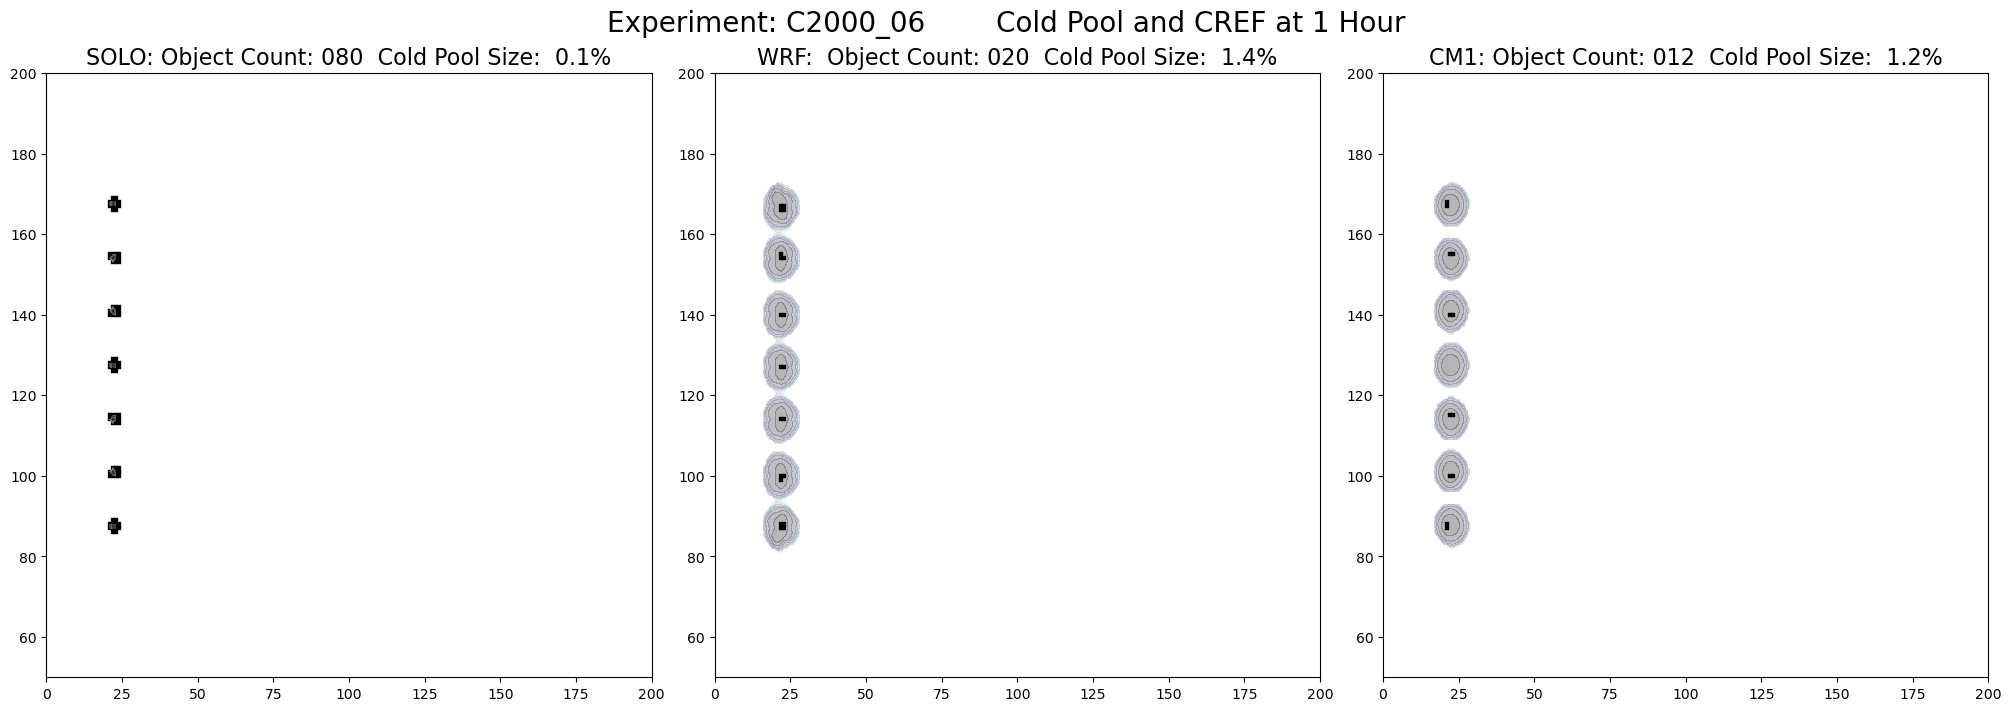

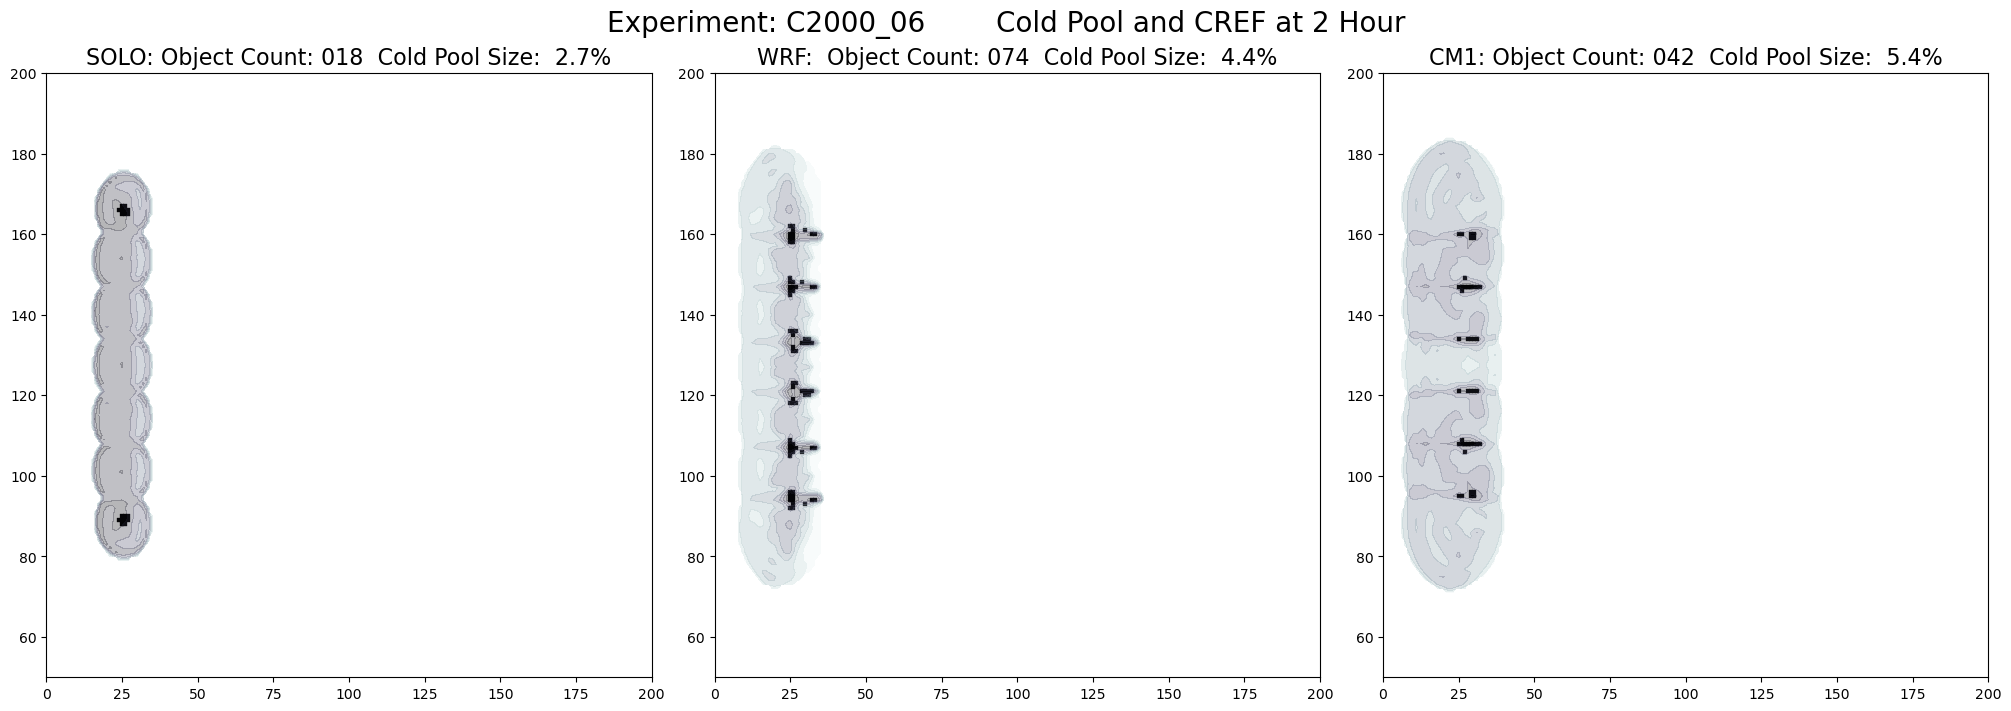

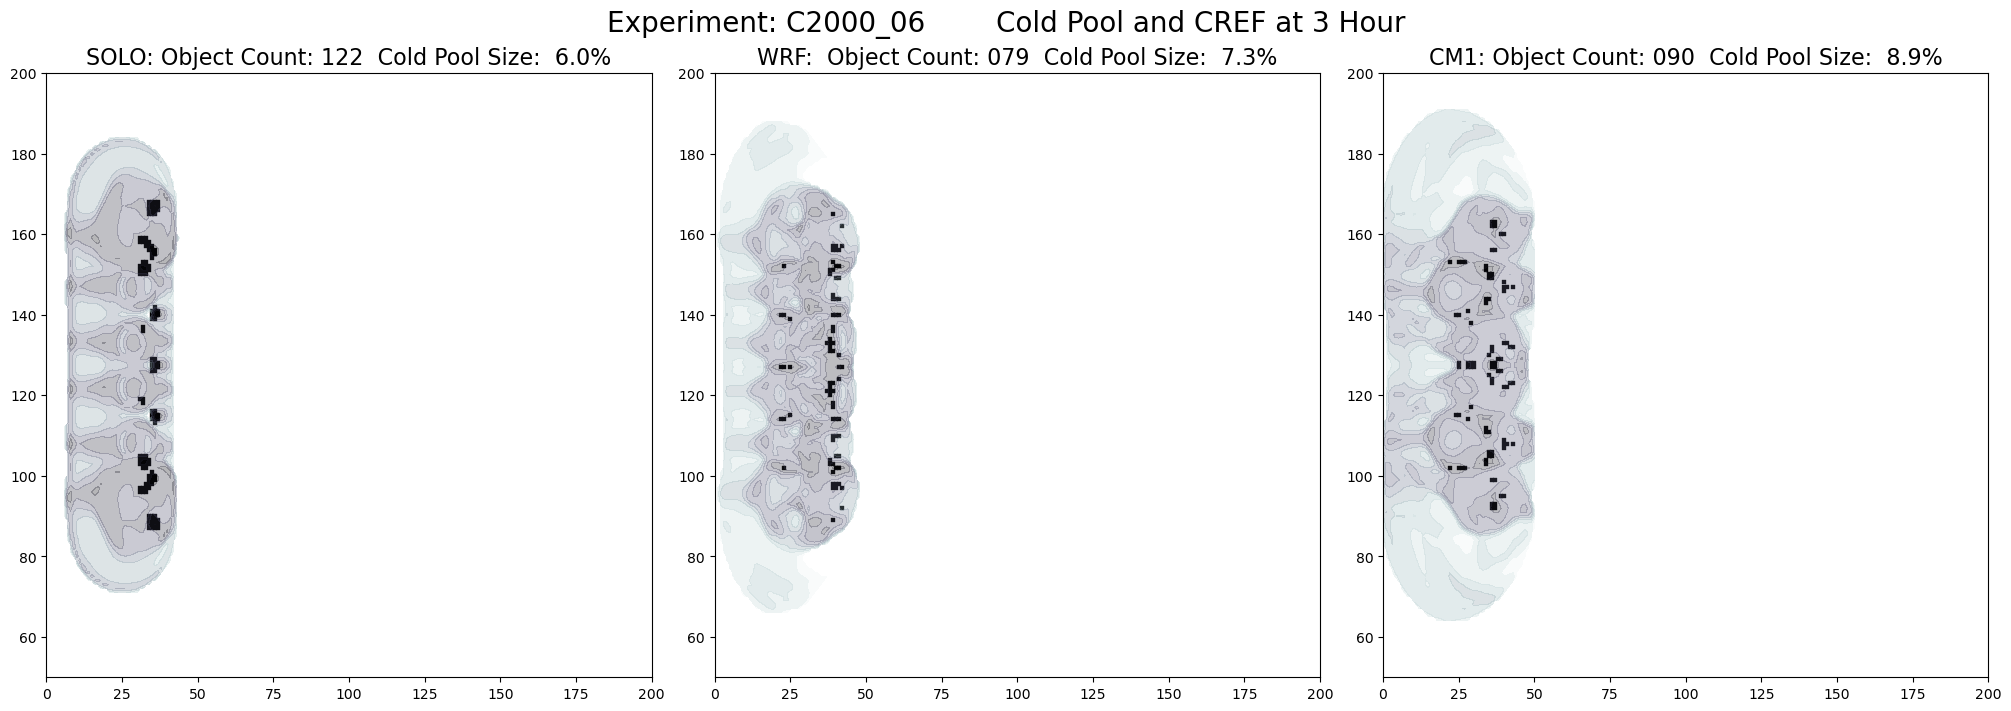

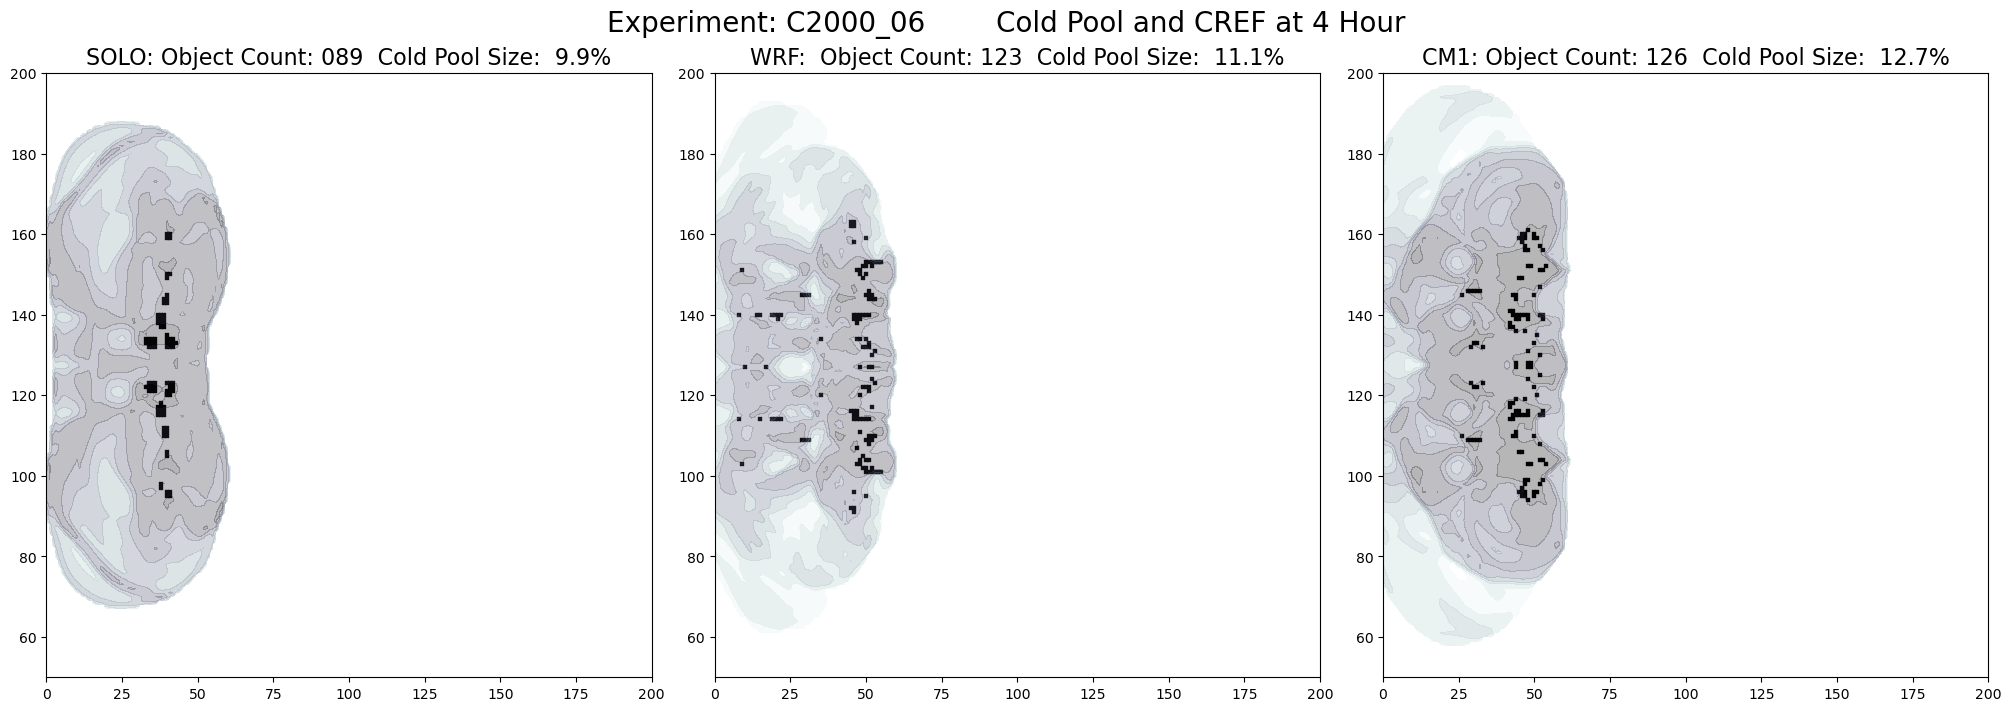

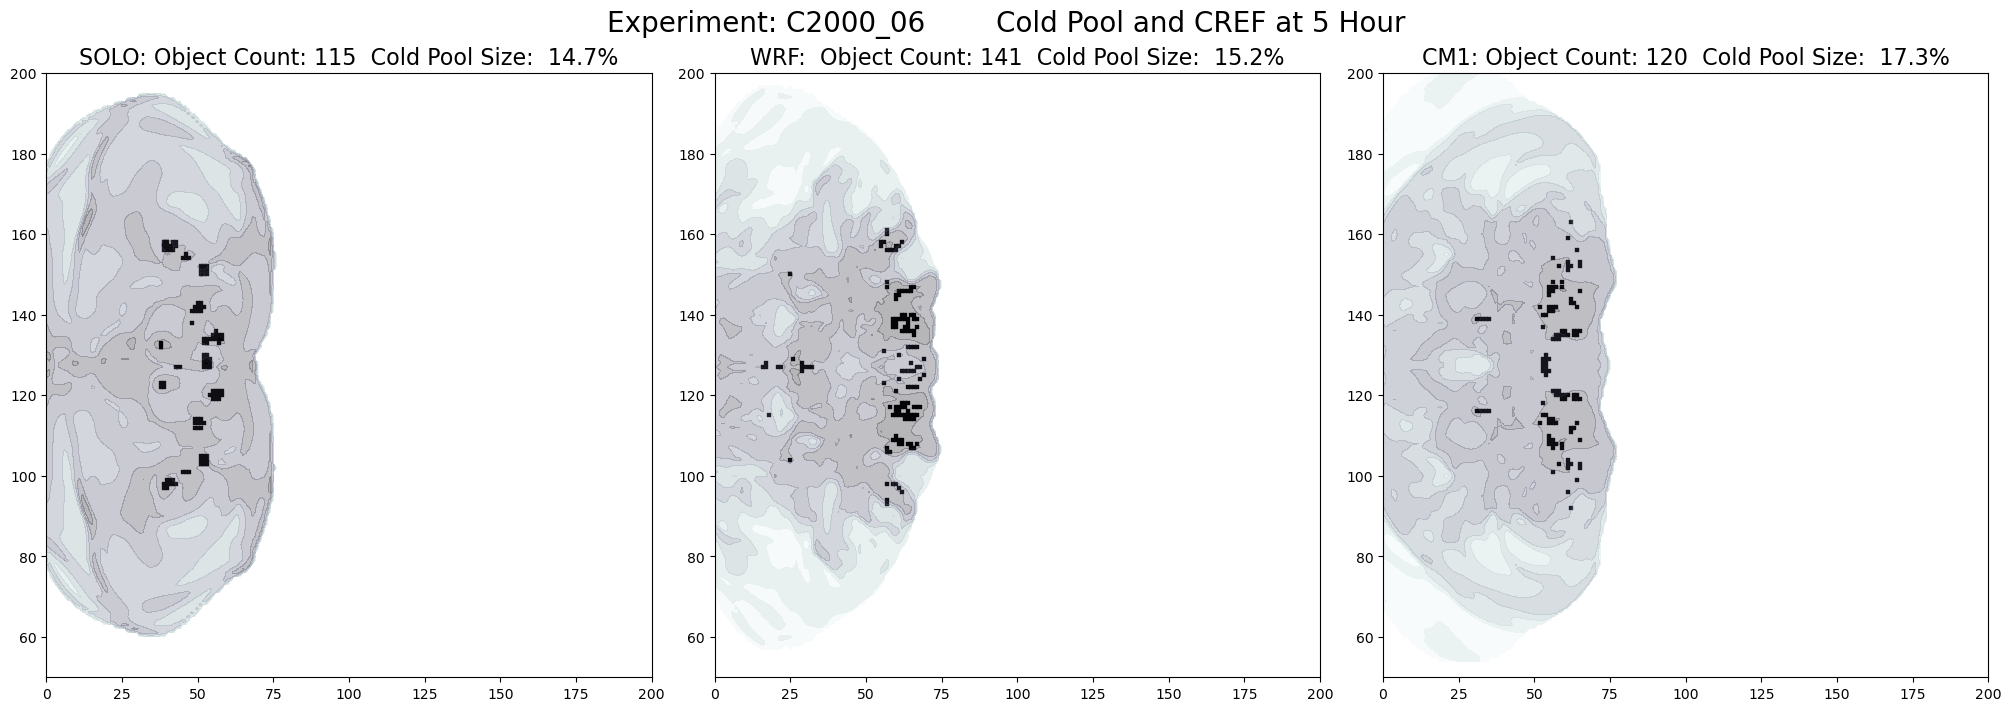

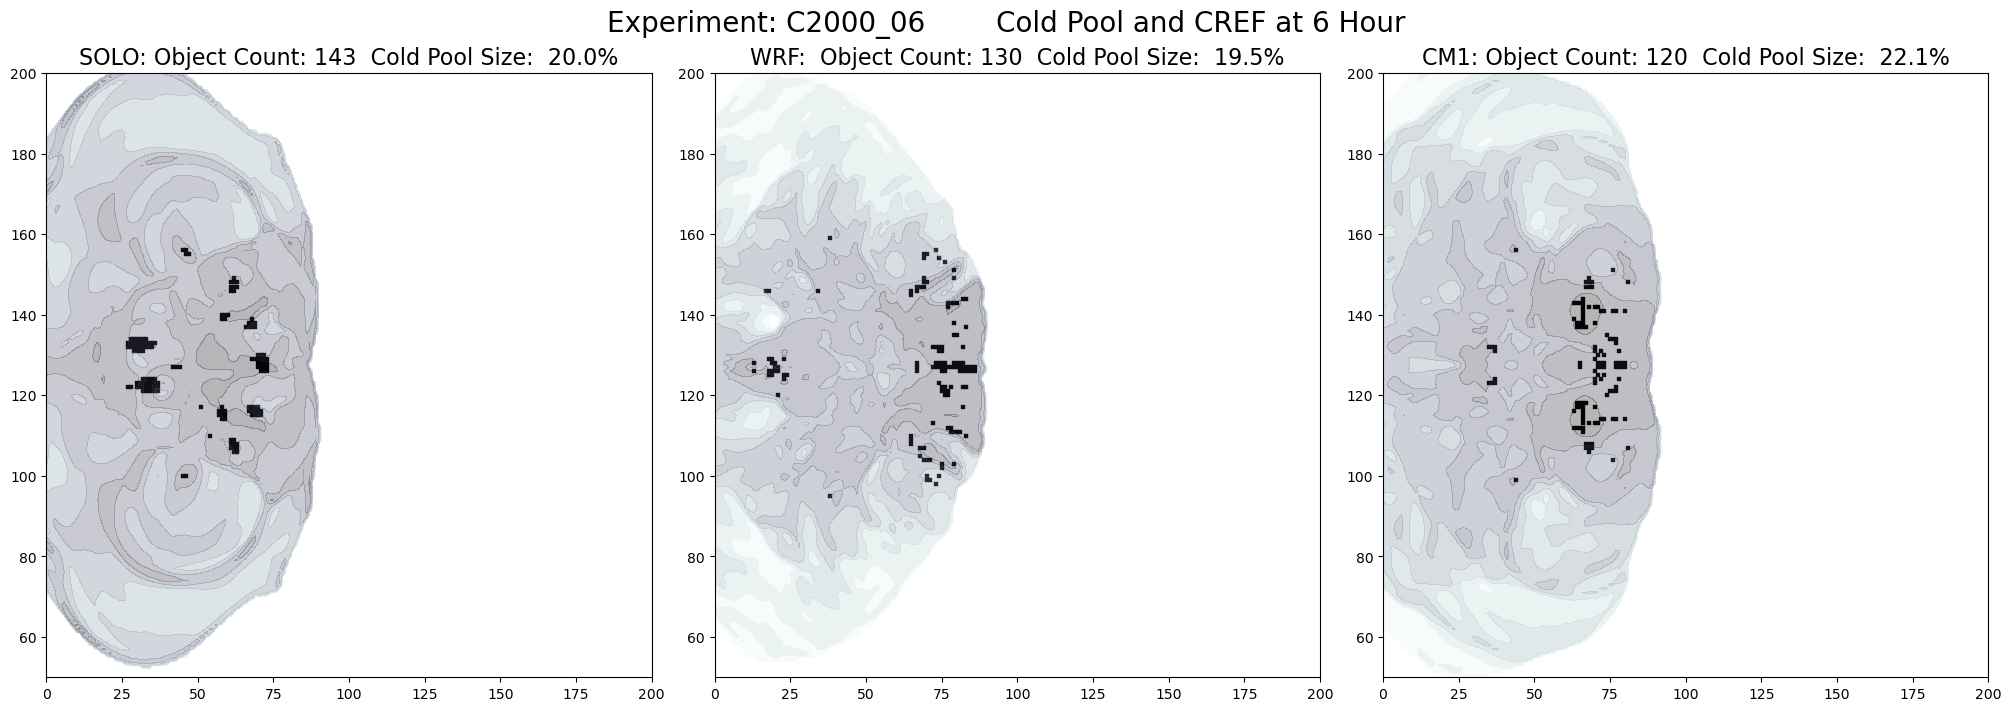

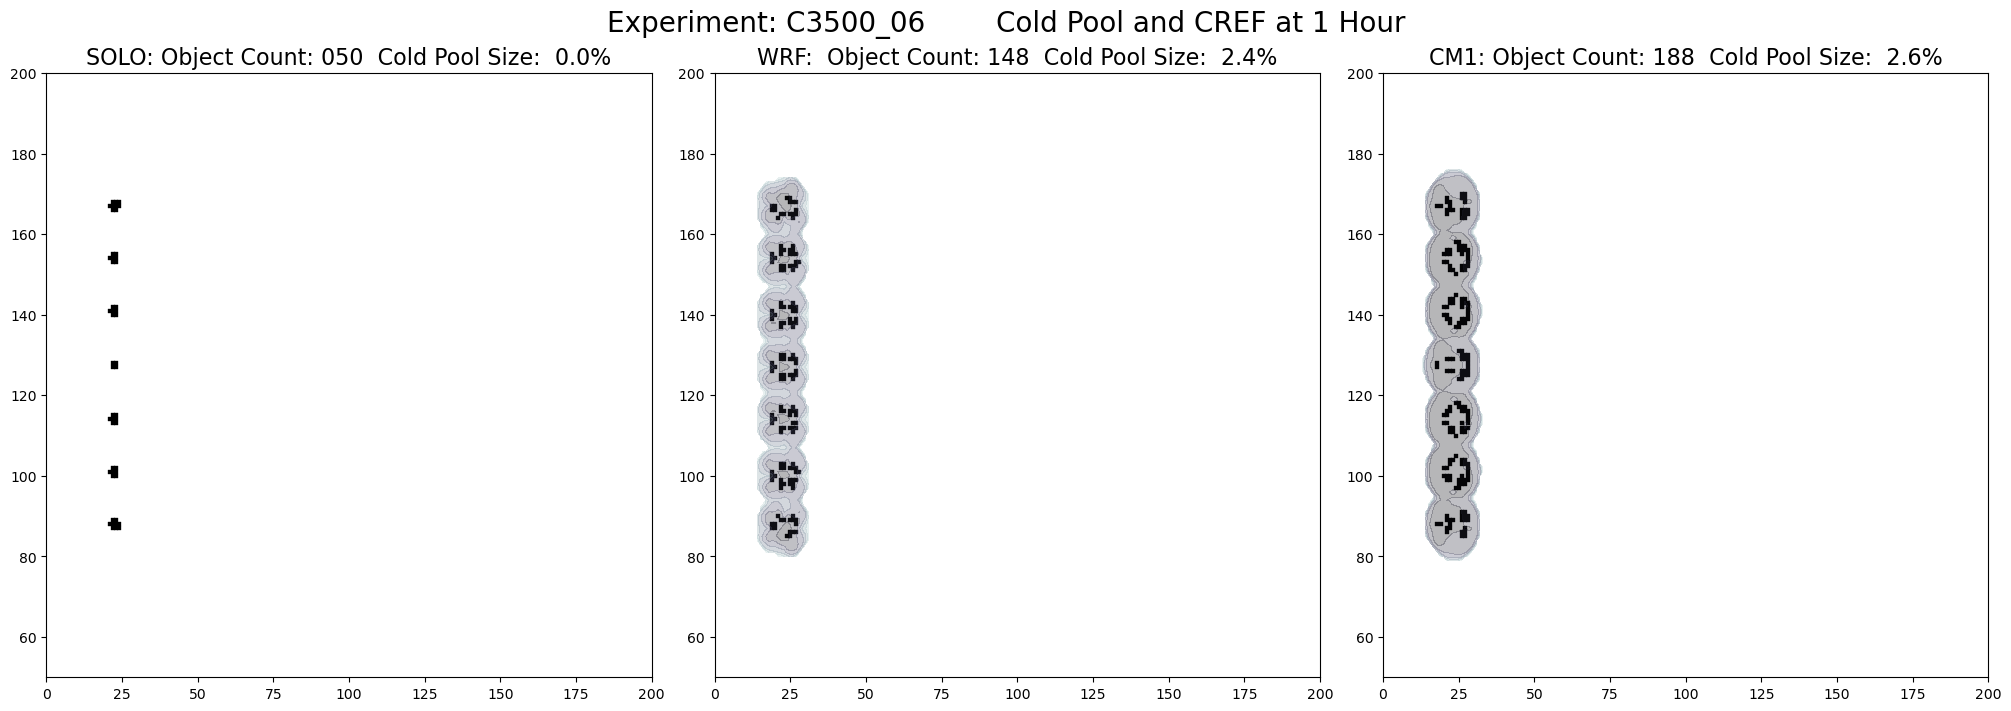

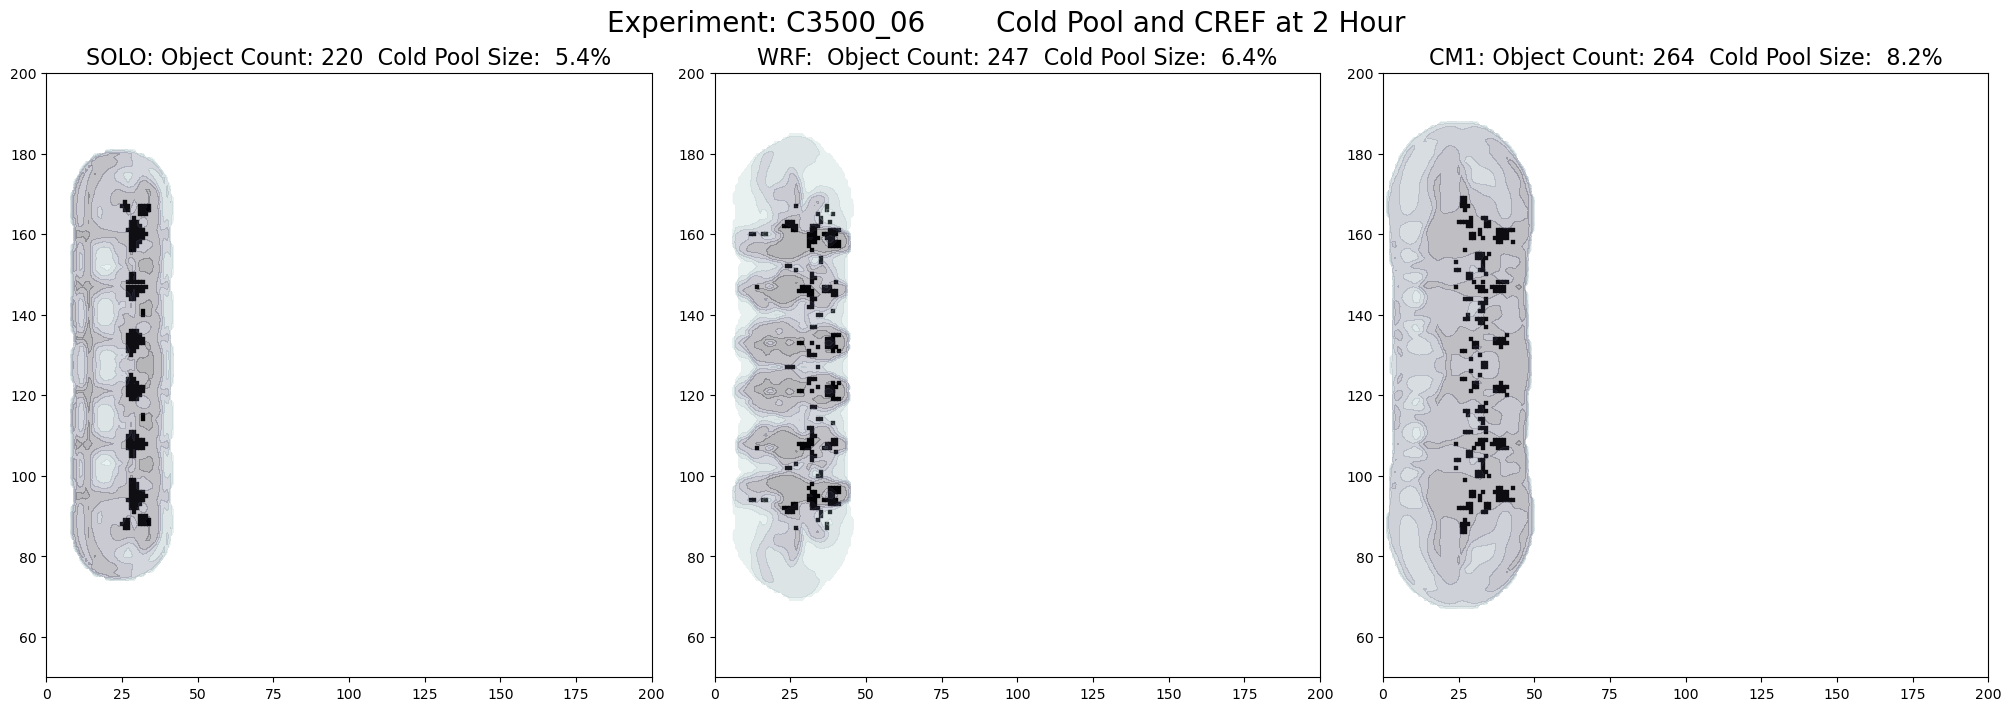

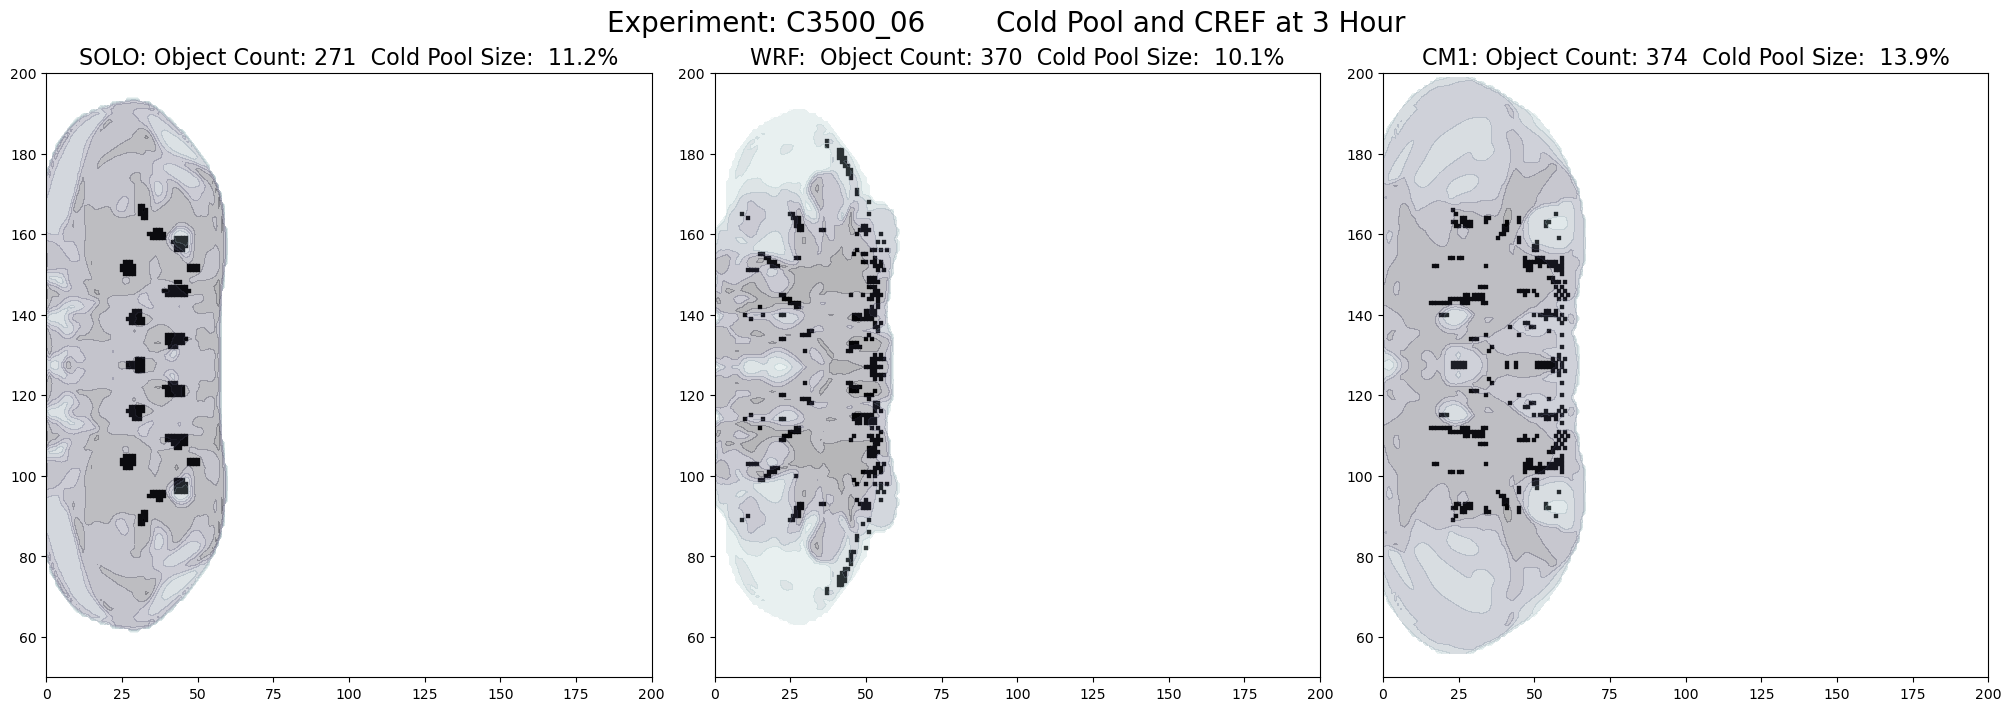

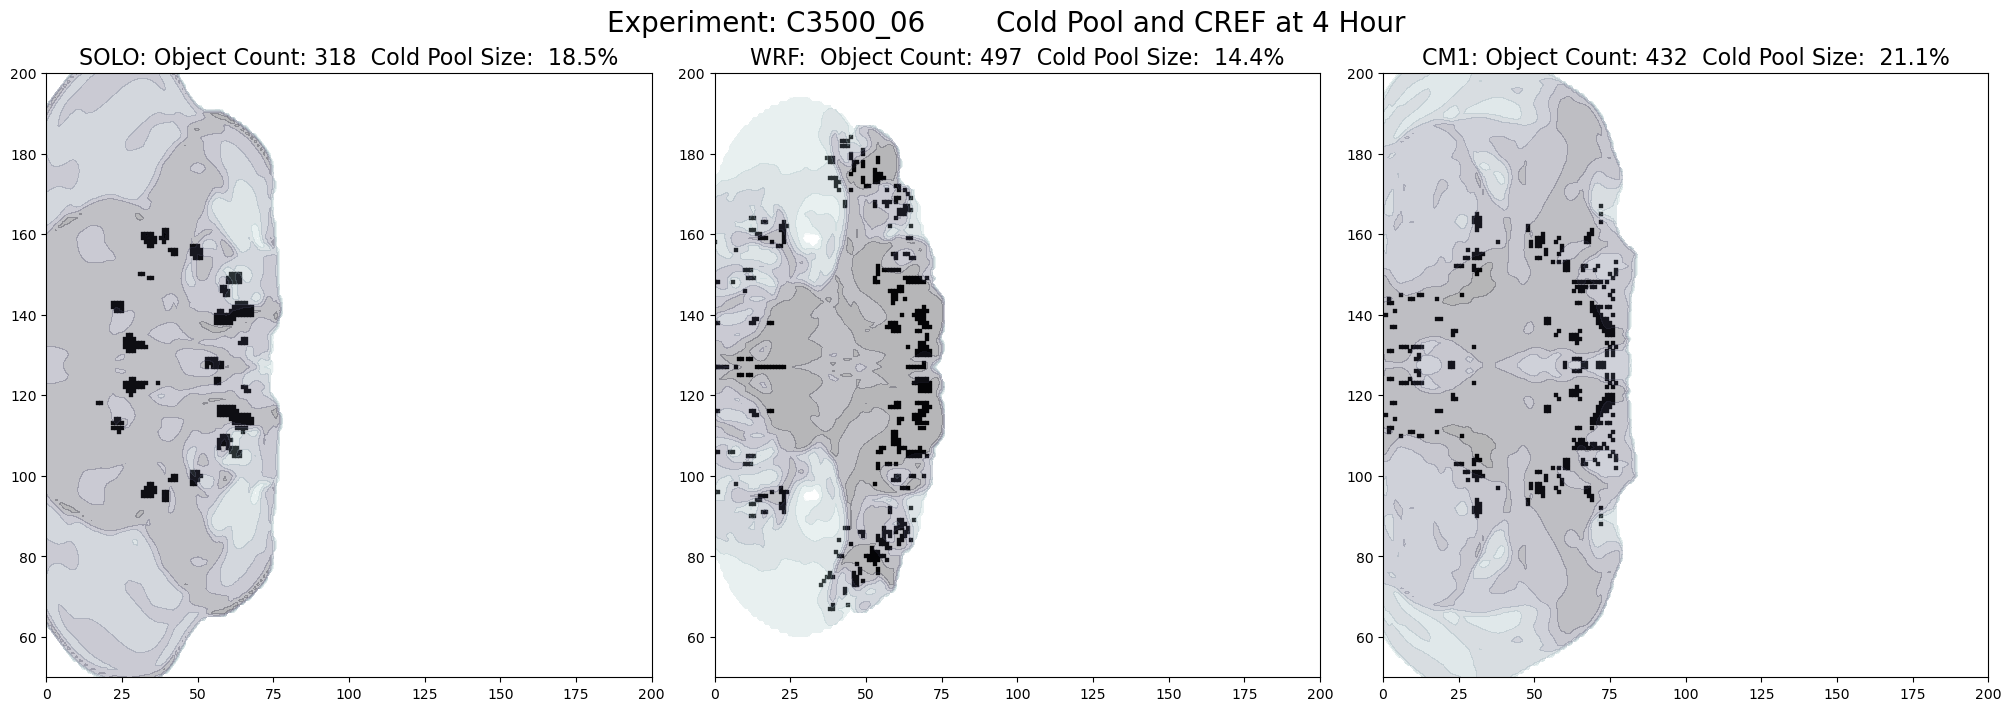

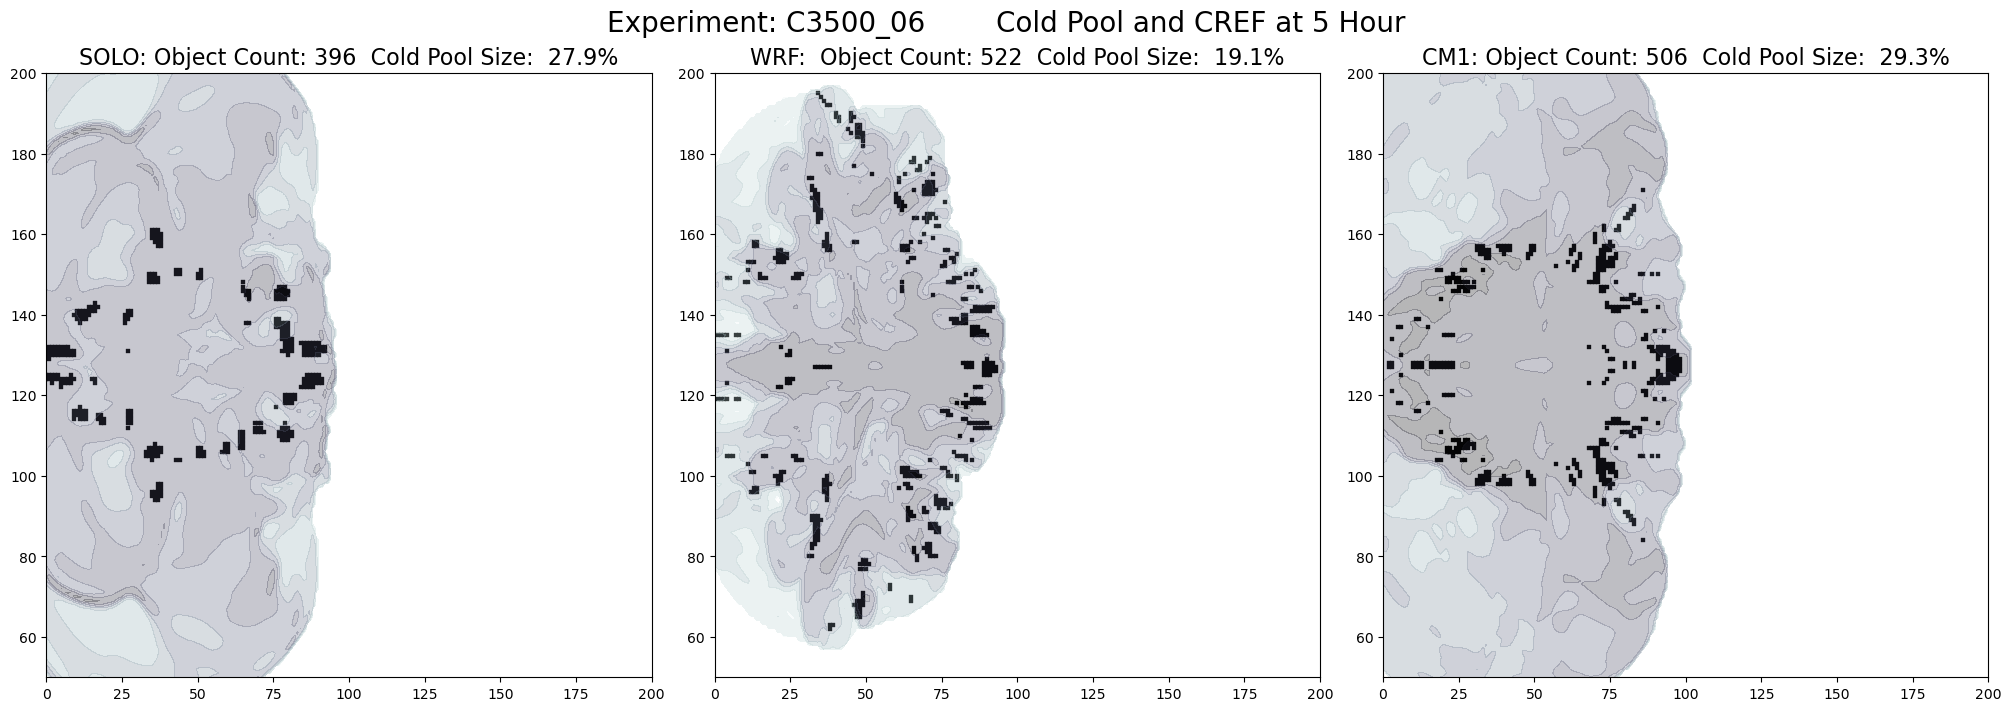

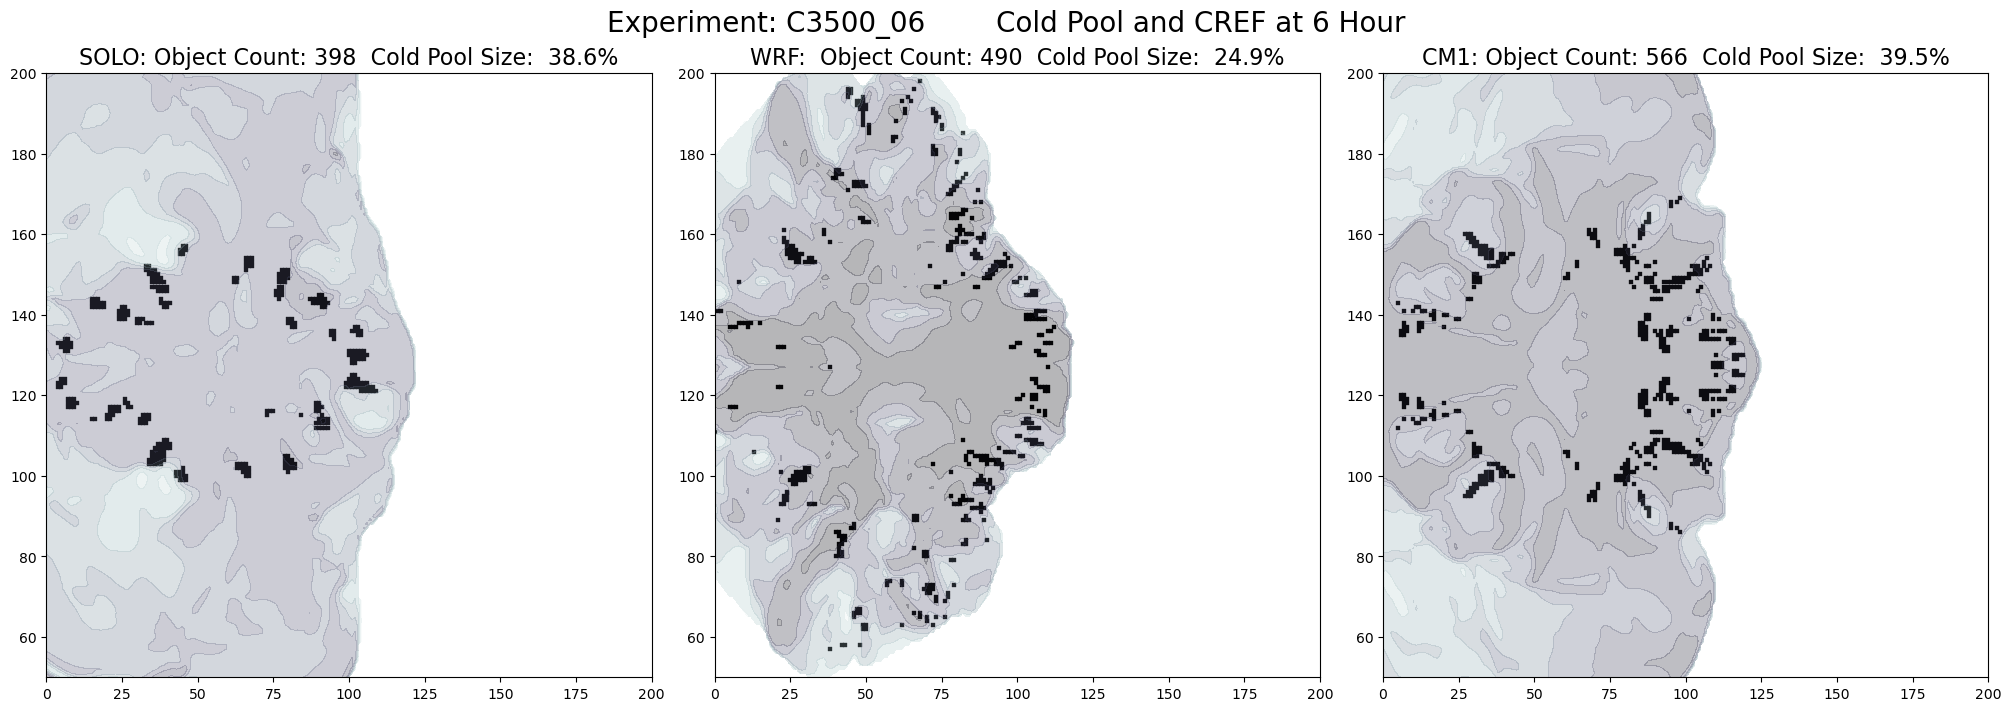

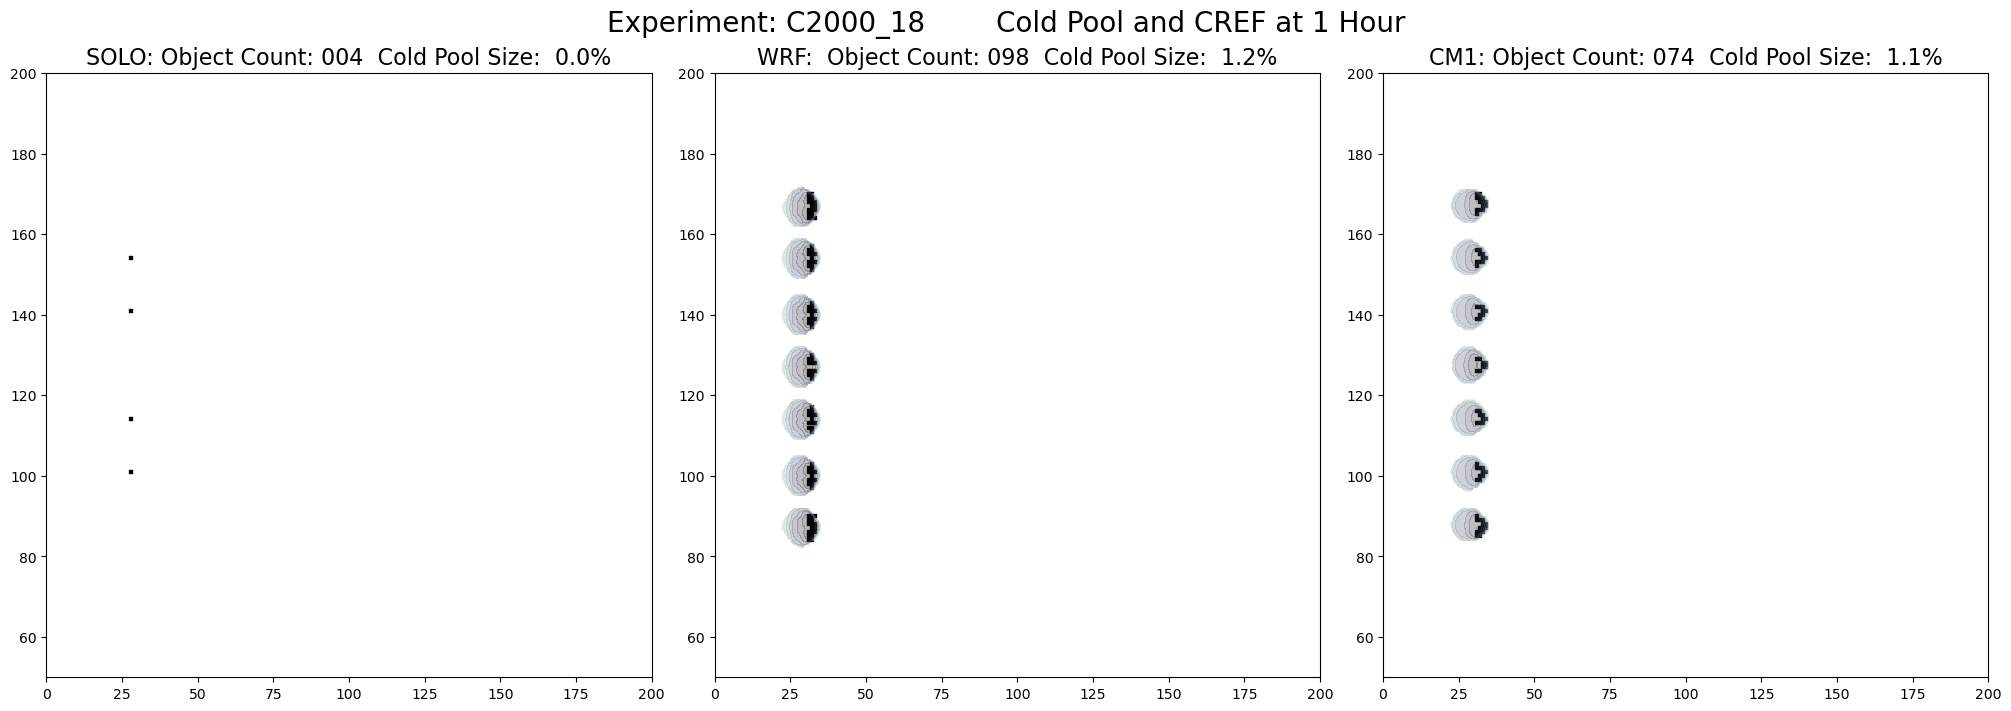

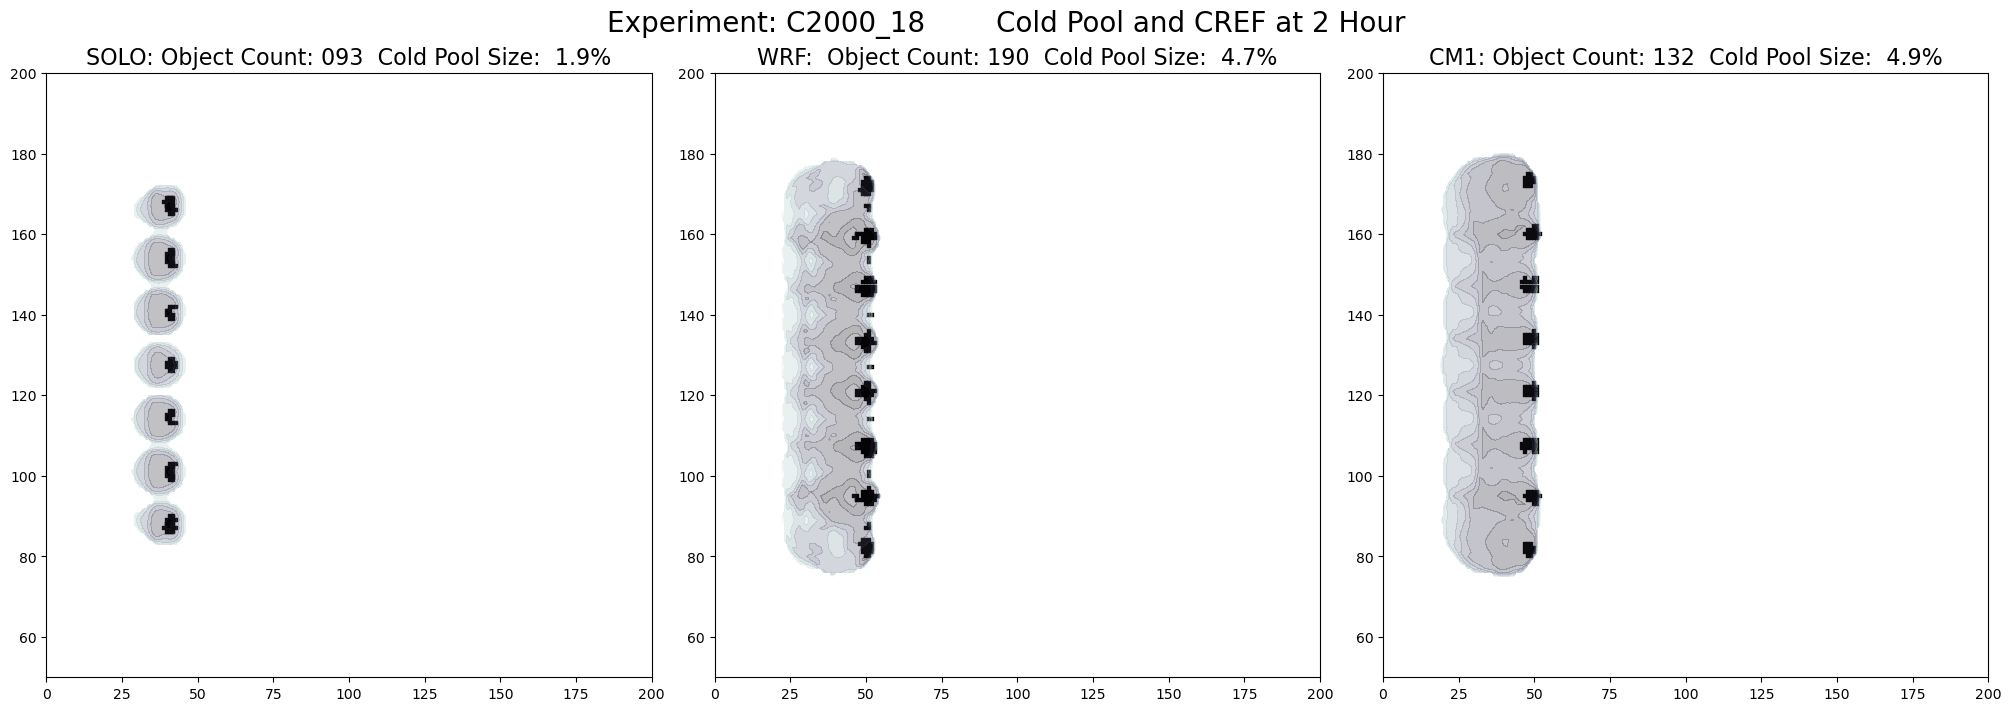

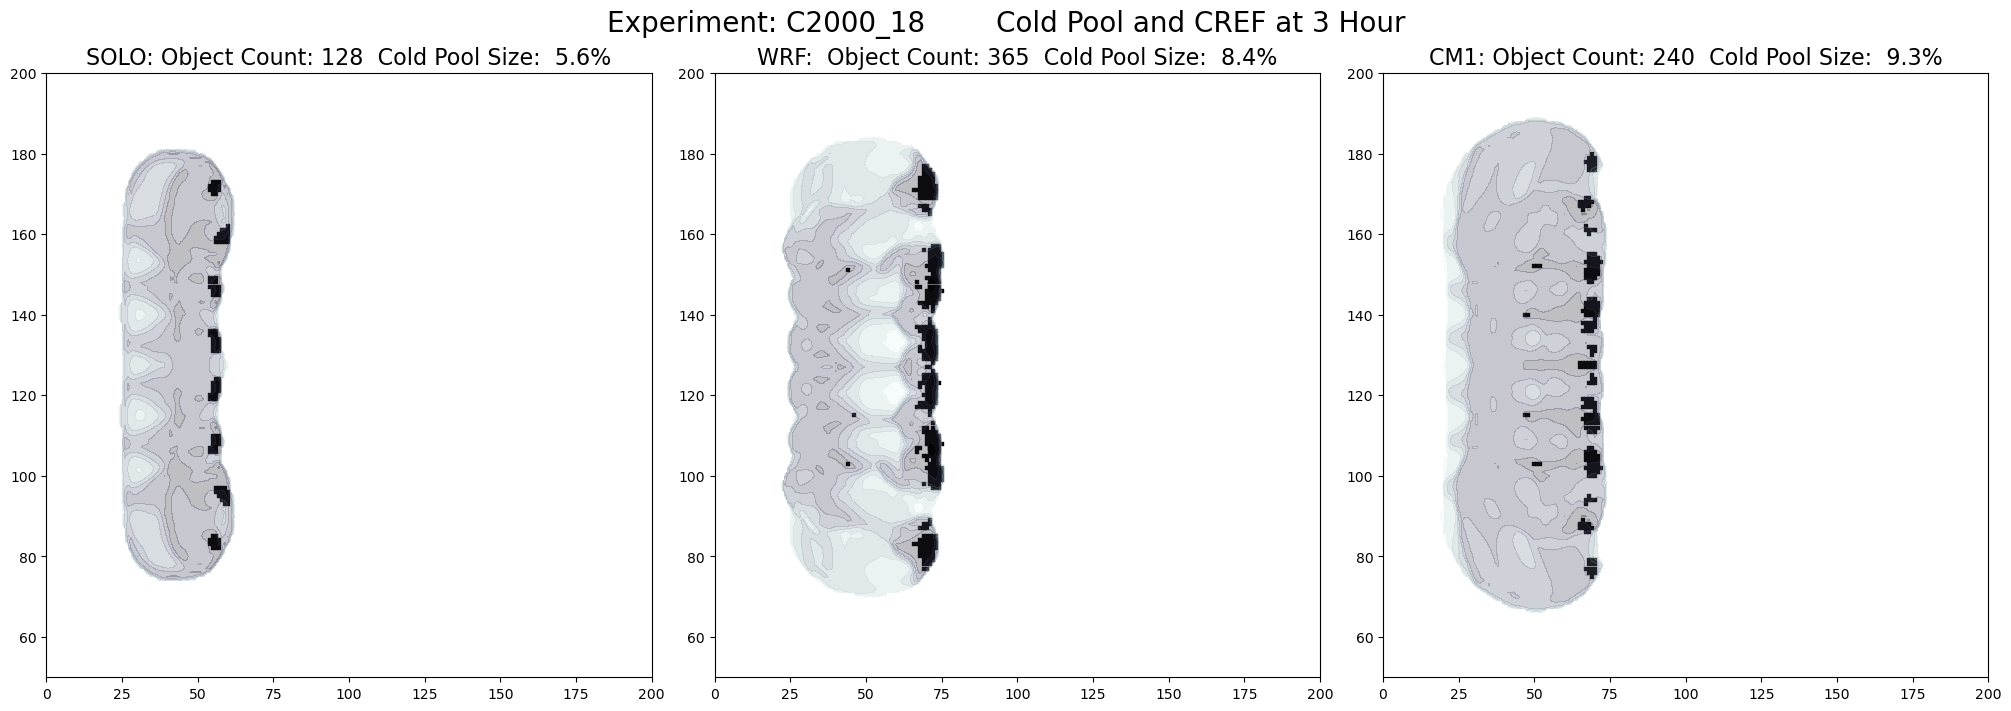

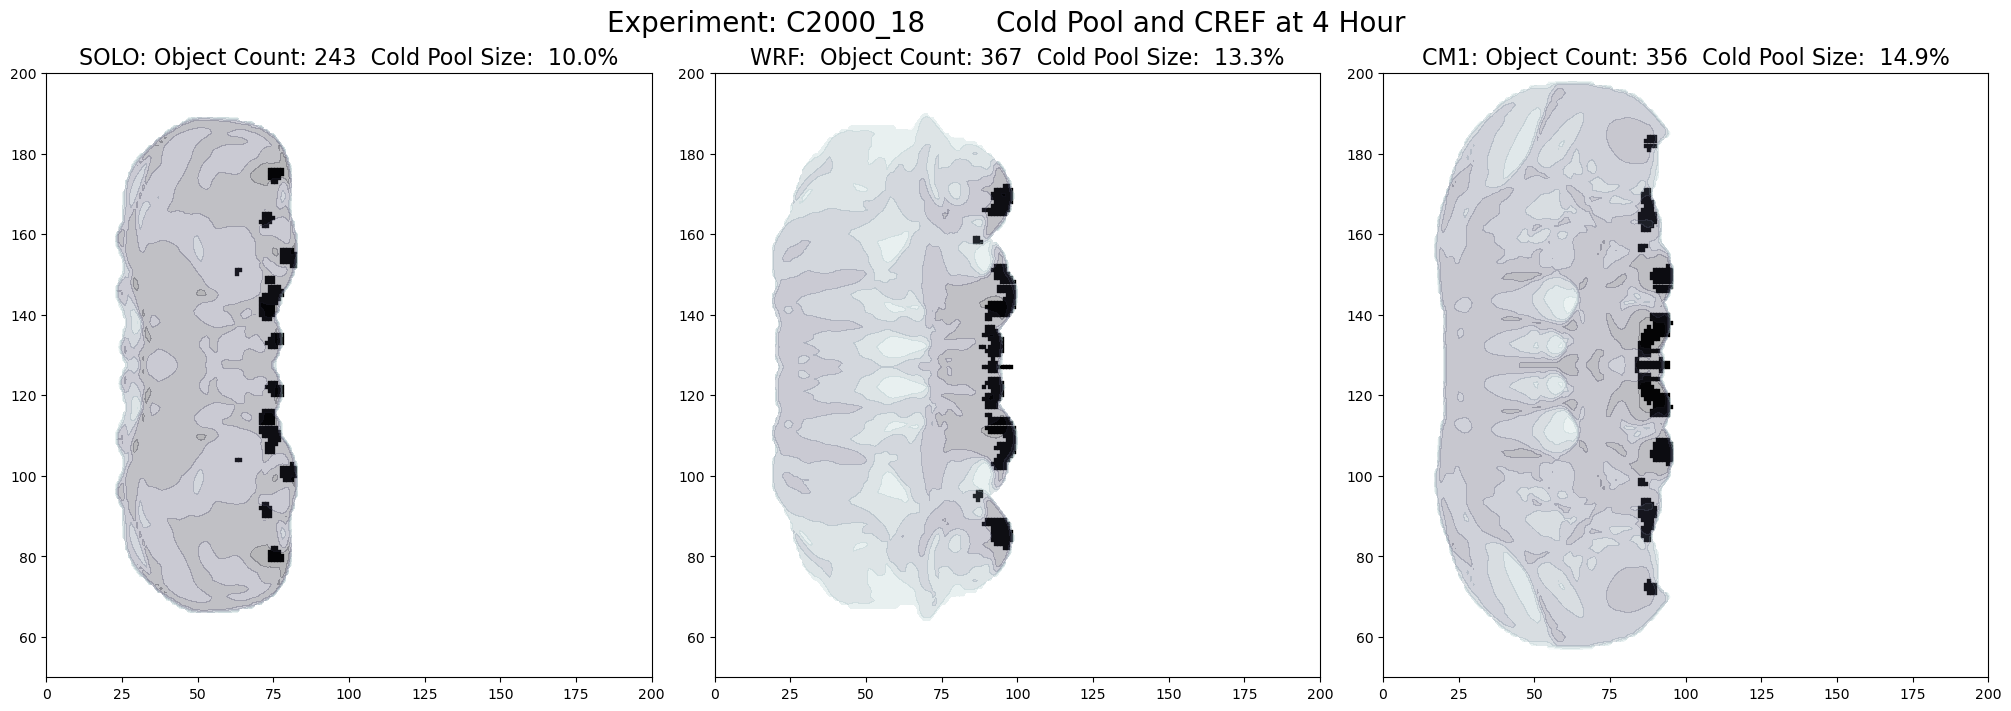

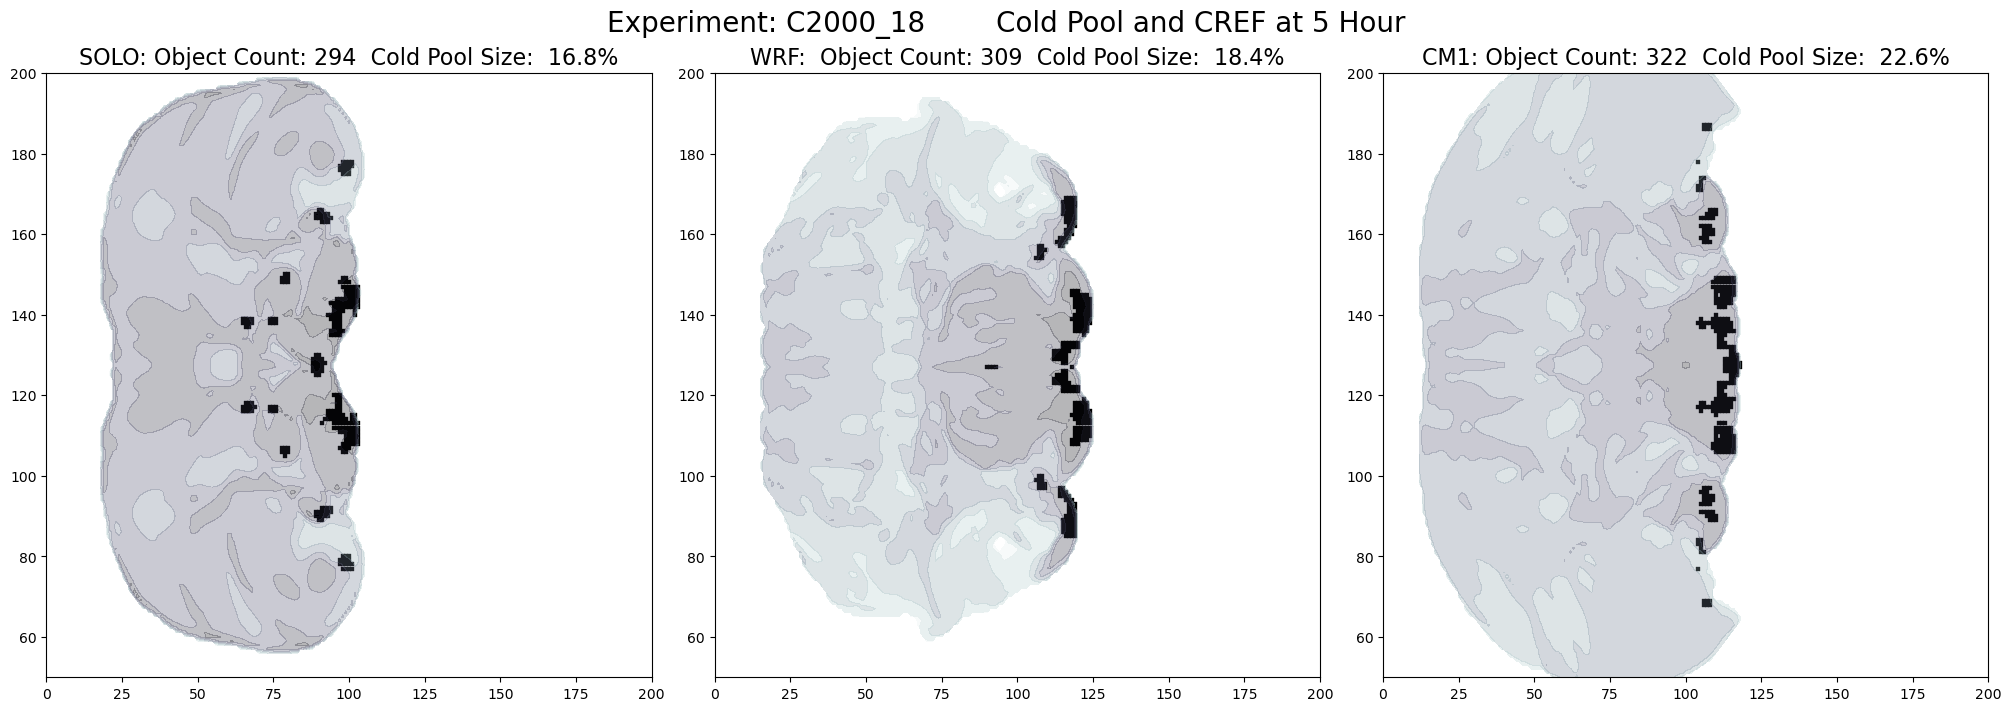

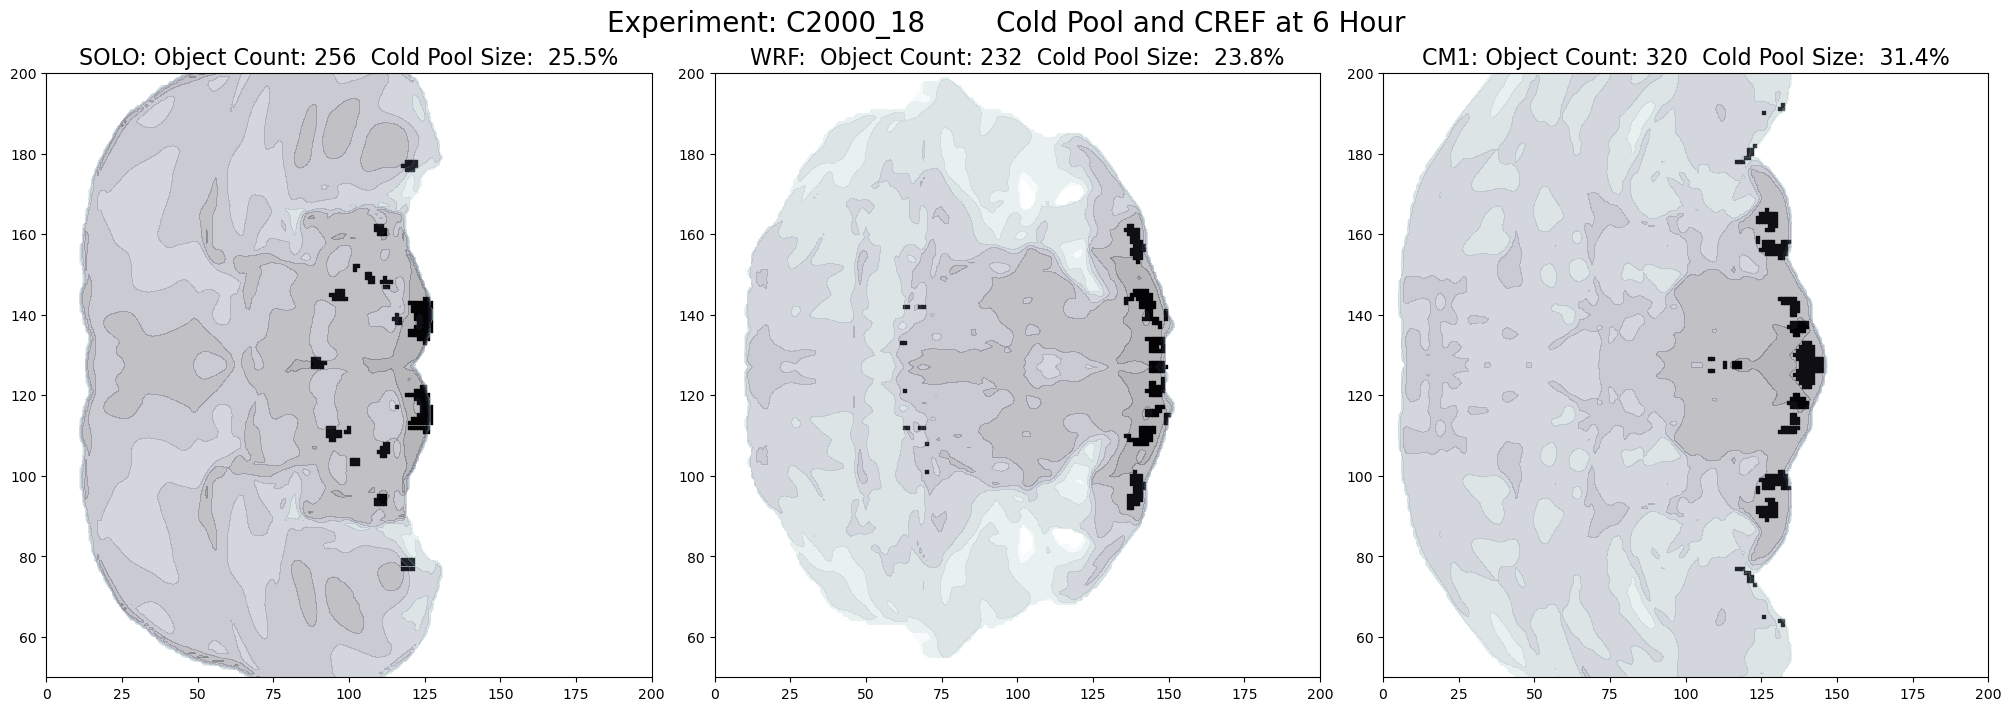

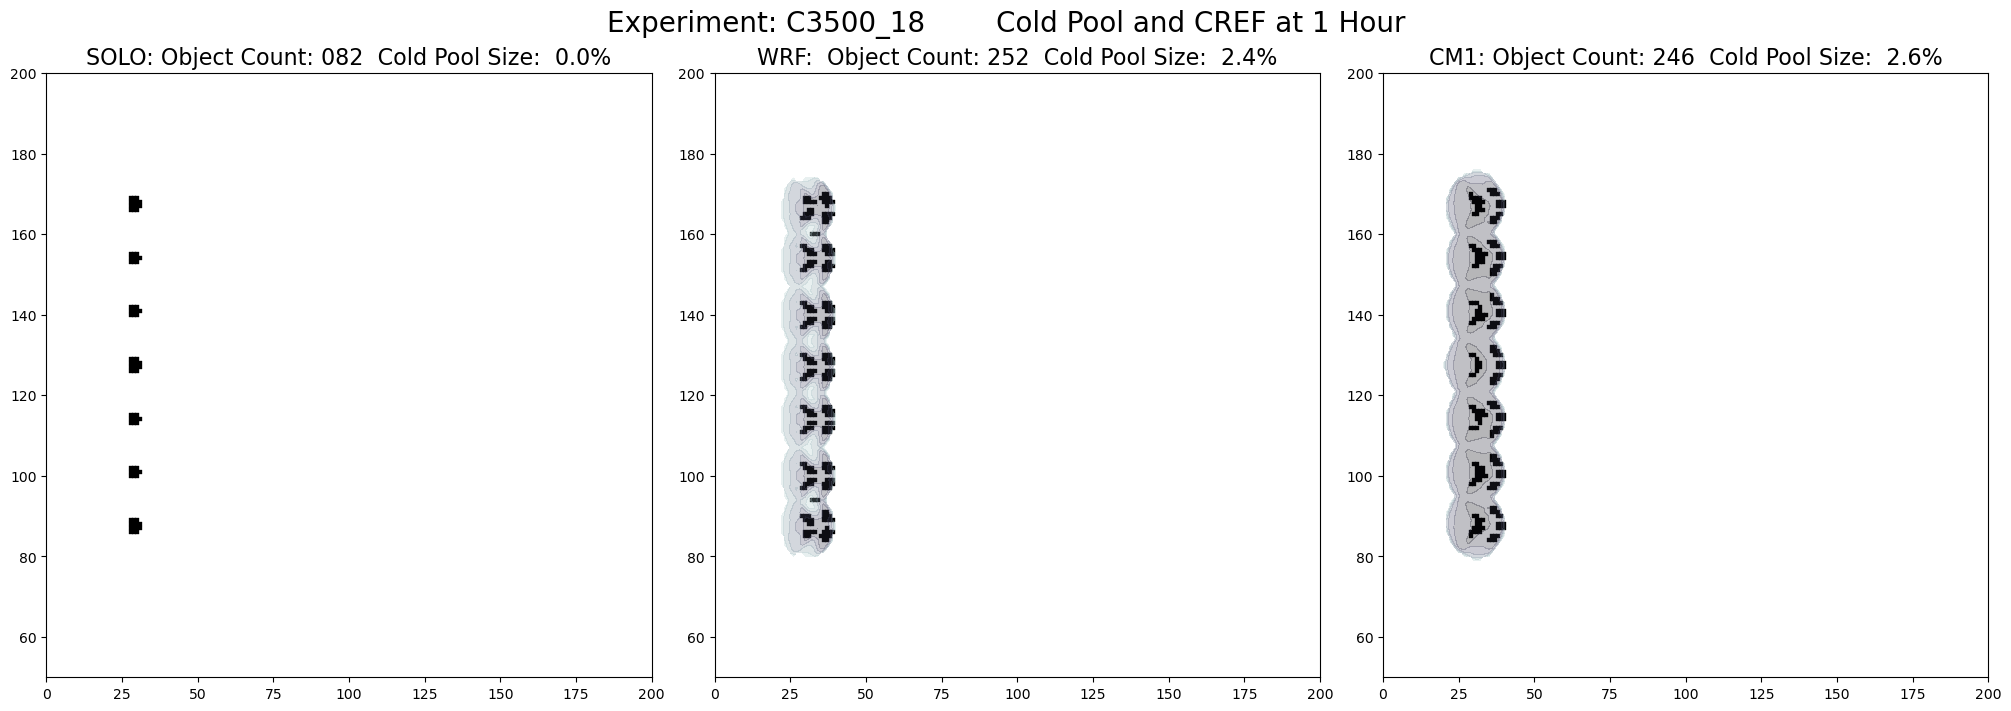

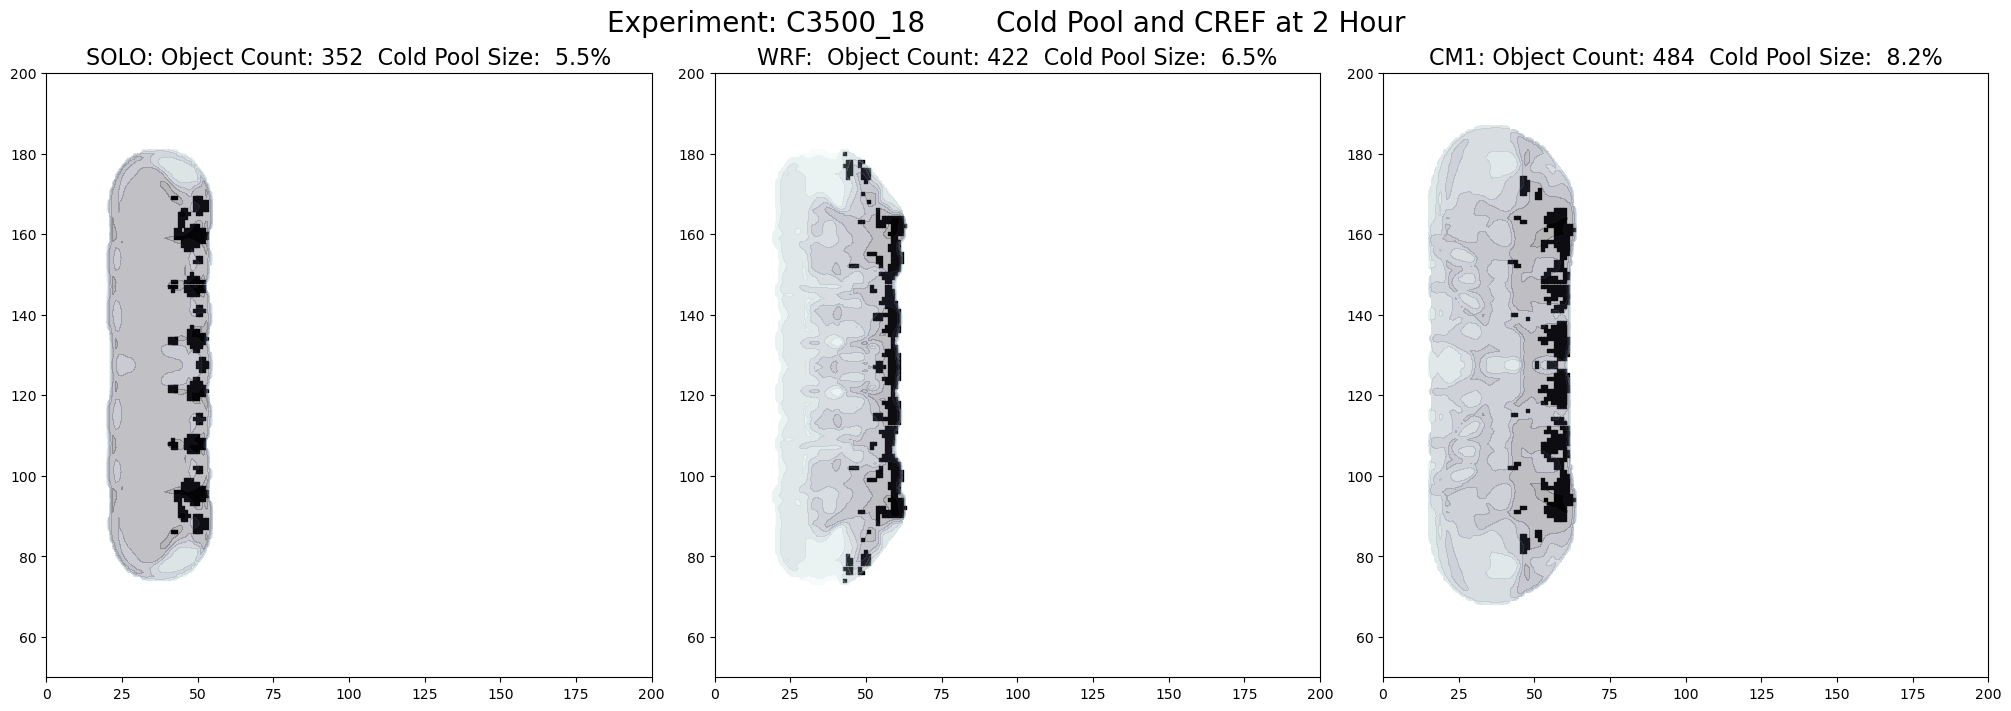

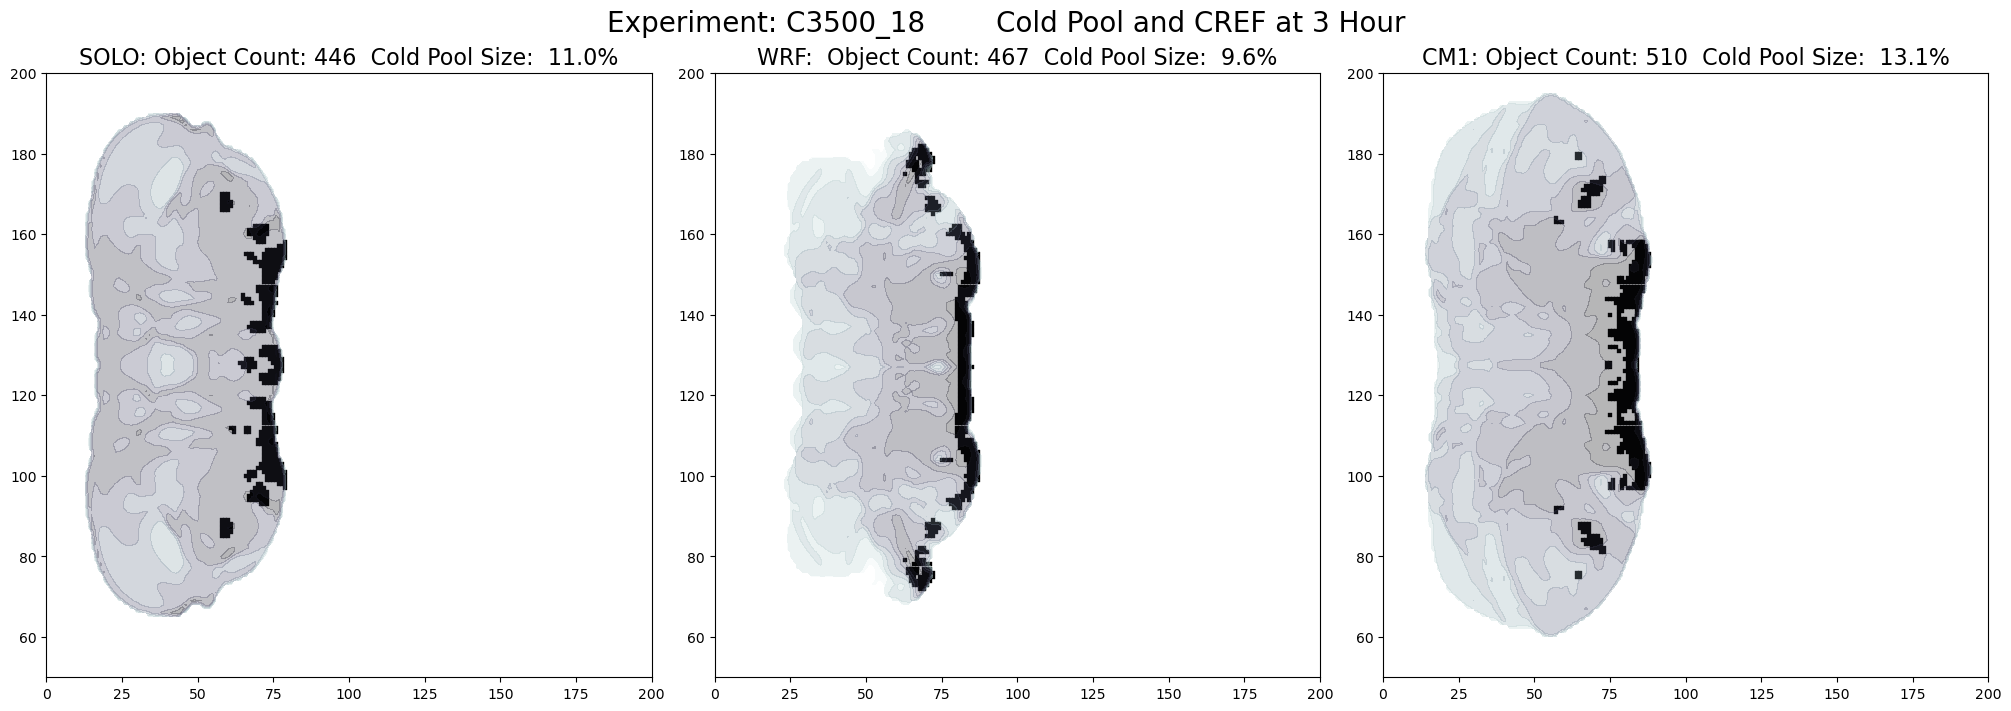

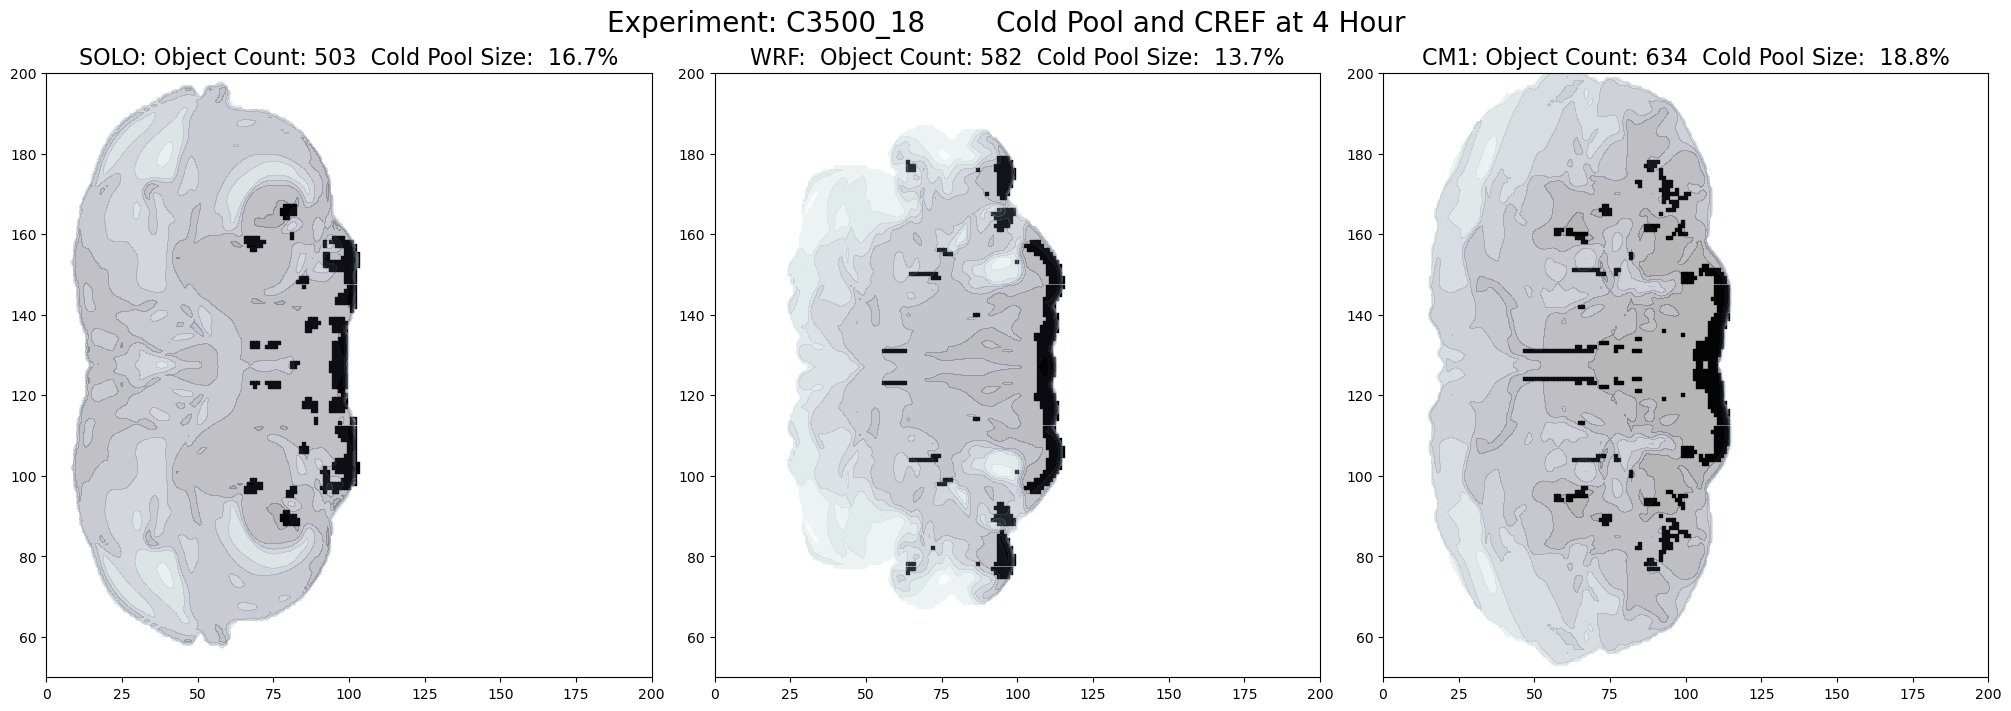

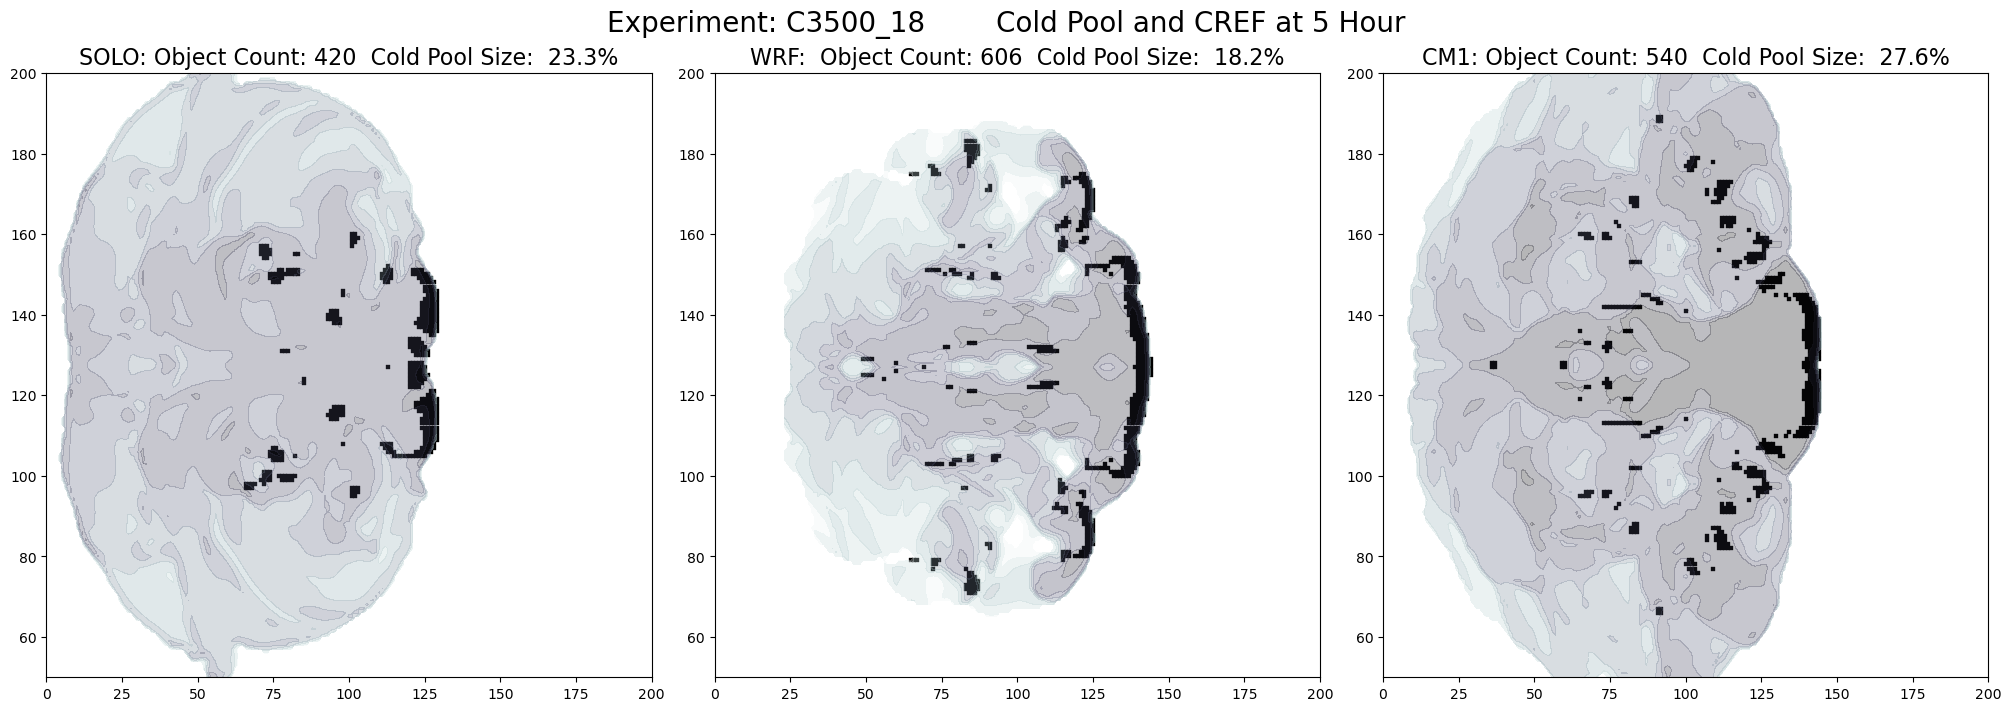

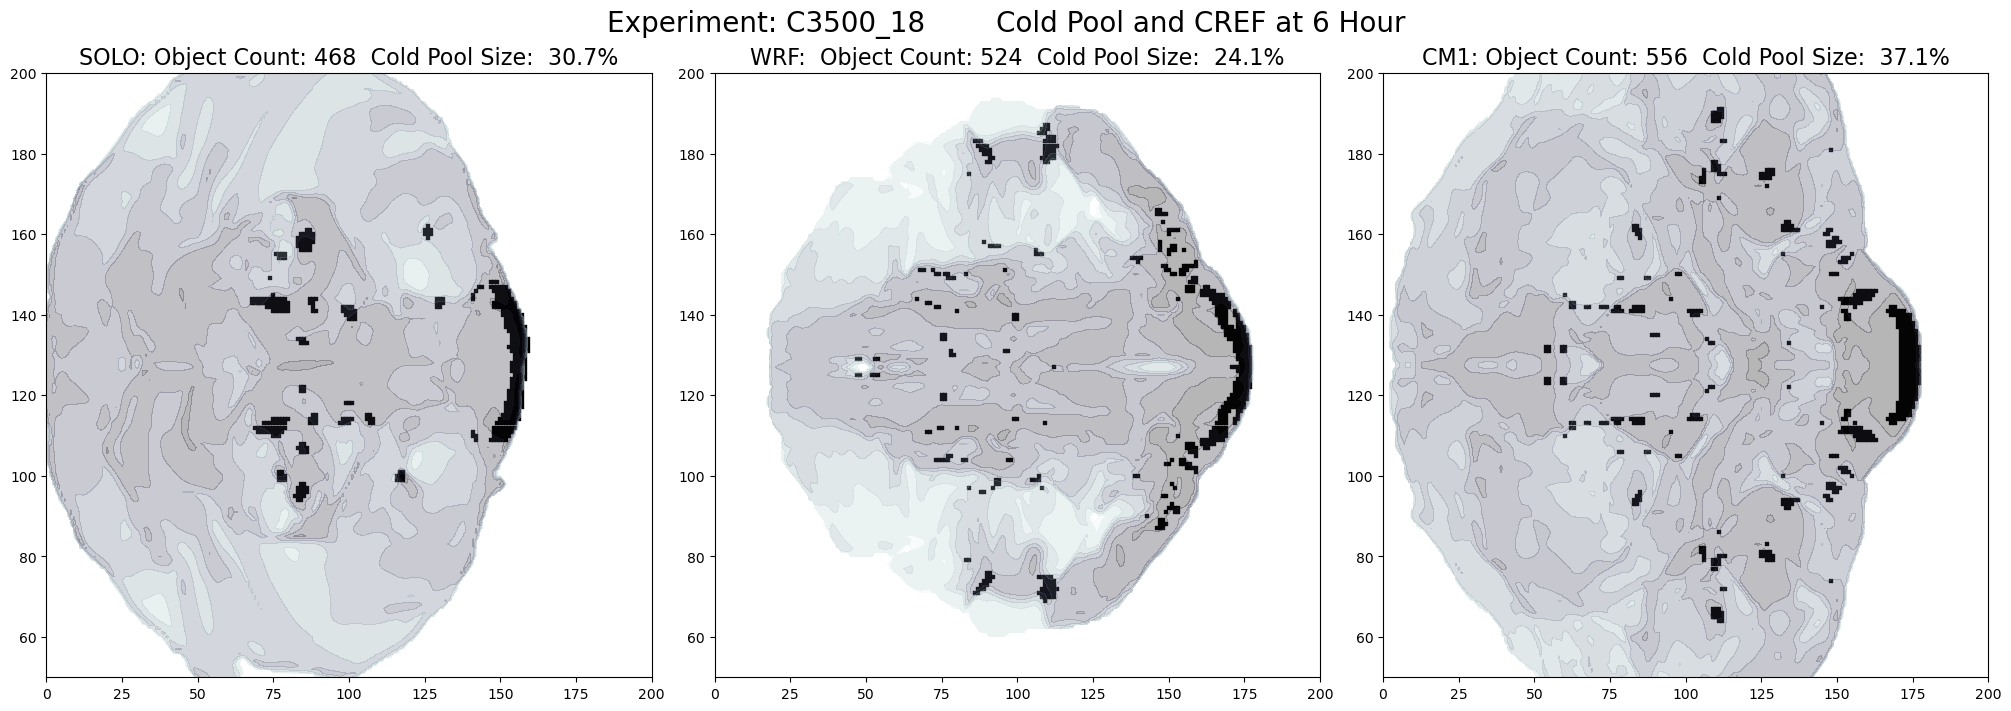

In [3]:
# Just read stuff back in...
            
def plotobj(data, label, time = 8, ax = None, colors='k', alpha=1.0, cref_thresh = 35., marker="s", w_thresh=5.):
    
    DBZ  = data[label]['dbz'][time]
    W    = data[label]['w'][time]
    PRES = data[label]['pres'][time]
    THpert  = data[label]['pert_th'][time]
        
    mask_cref   = np.where(DBZ.max(axis=0) > cref_thresh, True, False)
    mask_w_3d   = np.where(PRES < 70000.0, W, np.nan)

    mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
    mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
    f_mask      = mask_w_cref.astype(np.int8)
    
    ctable = radar_colormap()
    levels = [5 + 5*n for n in range(15)]
    
    x = np.arange(DBZ.shape[1])
    y = np.arange(DBZ.shape[2])
    xx, yy = np.meshgrid(x,y)
    
    #ax.contour(DBZ.max(axis=0), levels=[35,], color='k')
    ax.scatter(xx[f_mask>0], yy[f_mask>0], s=10, c=colors, marker=marker, alpha=alpha, linewidths=0.25)
    
    #ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,-2], color='b', alpha=0.5)
    ax.contourf(np.where(THpert[0] < -1.0, THpert[0], np.nan), clevels=[-1,], cmap=plt.get_cmap('bone'), alpha=0.3)

    ax.set_ylim(50., 200.)
    ax.set_xlim(0., 200.)
    
    return np.sum(f_mask > 0), 100*np.where(THpert[0] < -1.0, 1.0, 0.0).sum()/(THpert[0].shape[0]*THpert[0].shape[1])

#-----------------------------
allcape = ("C2000","C3500")
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:
        
        for n in [1,2, 3, 4, 5, 6]:
            

            fig, ax = plt.subplots(1,3, constrained_layout=True,figsize=(20,7))

            label = "%s_%s" % (cape, shear)

            o4, pix = plotobj(solo, label, ax = ax[0], time=n*4-1, colors='k', marker="s")

            ax[0].set_title("SOLO: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(wrf, label, ax = ax[1], time=1+n*4-1, colors='k', marker="s")

            ax[1].set_title("WRF:  Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            o4, pix = plotobj(cm1, label, ax = ax[2], time=1+n*4-1, colors='k', marker="s")

            ax[2].set_title("CM1: Object Count: %3.3d  Cold Pool Size:  %3.1f%%" % (o4, pix), fontsize=16)

            plt.suptitle("Experiment: %s        Cold Pool and CREF at %d Hour" % (label, n), fontsize=20)
            
            plt.savefig("Experiment_%s_Marker_Hour%d.png" % (label, n))

            plt.show()

In [ ]:
def countobj(data, label, cref_thresh = 35., w_thresh=5.):
    
    DBZ  = data[label]['dbz']
    W    = data[label]['w']
    PRES = data[label]['pres']

    ntimes = DBZ.shape[0]
    fcount = []
    
    for n in np.arange(ntimes):
        mask_cref   = np.where(DBZ[n].max(axis=0) > cref_thresh, True, False)
        mask_w_3d   = np.where(PRES[n] < 70000.0, W[n], np.nan)

        mask_w_2d   = np.nanmax(mask_w_3d, axis=0)
        mask_w_cref = (mask_w_2d > w_thresh) & mask_cref
        f_mask      = mask_w_cref.astype(np.int8)
    
        fcount.append(np.sum(f_mask > 0))
        
    return fcount

#-----------------------------
allcape = ("C2000","C3500",)
allshear = ("06","18")

for shear in allshear:
    for cape in allcape:

        fig, ax = plt.subplots(1,1, constrained_layout=True,figsize=(15,5))
        
        label = "%s_%s" % (cape, shear)
        
        scount = countobj(solo, label)
        wcount = countobj(wrf, label)
        ccount = countobj(cm1, label)
        
        ntimes = 15+15*np.arange(len(scount))
        
        ax.plot(ntimes, scount, color='r', label='FV3_SOLO')
        
        ntimes = 15*np.arange(len(wcount))

        ax.plot(ntimes, wcount, color='k', label='WRF')
        ax.plot(ntimes, ccount, color='b', label='CM1')
        
        ax.set_ylabel('Number of Objects', fontsize=16)
        ax.set_xlabel('Time (min)', fontsize=16)
        ax.set_ylim(0.0, 900)
        
        plt.title(label)
        
        plt.show()